# Result Analysis and Model Definition

## [Australian Tourism Hierarchy](https://otexts.com/fpp2/hts.html)

In [235]:
# Usual imports
import sys

sys.path.append("../src")

import os
from pprint import pprint
import importlib

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error

from pmdarima.model_selection import train_test_split

import warnings

warnings.filterwarnings("ignore")

%matplotlib inline
%load_ext autoreload
%autoreload 2

%matplotlib inline

# Download the raw files into this directory
data = '../data/raw/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Loading Data

In [3]:
DATAPATH = os.path.join(data, "visnights")
os.listdir(DATAPATH)

['visnights.csv']

In [4]:
visnights = pd.read_csv(os.path.join(DATAPATH, "visnights.csv"))
visnights.head(7)

date state   zone  total_visitors_nights
0  1998-01-01   NSW  Metro            9047.095397
1  1998-04-01   NSW  Metro            6962.125890
2  1998-07-01   NSW  Metro            6871.963047
3  1998-10-01   NSW  Metro            7147.292612
4  1999-01-01   NSW  Metro            7956.922814
5  1999-04-01   NSW  Metro            6542.243263
6  1999-07-01   NSW  Metro            6330.364078

In [5]:
visnights['date'] = pd.to_datetime(visnights['date'])

In [6]:
visnights["state_zone"] = visnights.apply(lambda x: f"{x['state']}_{x['zone']}", axis=1)

grouped_sections = visnights.groupby(["state", "state_zone"])
edges_hierarchy = list(grouped_sections.groups.keys())
edges_hierarchy[:7]

[('NSW', 'NSW_Metro'),
 ('NSW', 'NSW_NthCo'),
 ('NSW', 'NSW_NthIn'),
 ('NSW', 'NSW_SthCo'),
 ('NSW', 'NSW_SthIn'),
 ('OTH', 'OTH_Metro'),
 ('OTH', 'OTH_NoMet')]

In [7]:
second_level_nodes = ["NSW", "OTH", "WAU", "SAU", "QLD", "VIC"]
root_node = "total"

root_edges = [(root_node, second_level_node) for second_level_node in second_level_nodes]
root_edges

[('total', 'NSW'),
 ('total', 'OTH'),
 ('total', 'WAU'),
 ('total', 'SAU'),
 ('total', 'QLD'),
 ('total', 'VIC')]

In [8]:
root_edges += edges_hierarchy

In [9]:
visnights_bottom_level = visnights.pivot(index="date", columns="state_zone", values="total_visitors_nights")
visnights_bottom_level.head(5)

bottom_level = visnights_bottom_level.columns.tolist()

In [10]:
def get_state_columns(df, state):
    return [col for col in df.columns if state in col]

states = visnights["state"].unique().tolist()

for state in states:
    state_cols = get_state_columns(visnights_bottom_level, state)
    visnights_bottom_level[state] = visnights_bottom_level[state_cols].sum(axis=1)

visnights_bottom_level["total"] = visnights_bottom_level[states].sum(axis=1)

visnights_bottom_level.head(5)

state_zone    NSW_Metro    NSW_NthCo    NSW_NthIn    NSW_SthCo    NSW_SthIn  \
date                                                                          
1998-01-01  9047.095397  8565.677890  2977.506662  5818.028804  2679.537963   
1998-04-01  6962.125890  7124.468362  3477.702717  2466.436706  3010.732155   
1998-07-01  6871.963047  4716.893116  3014.770331  1928.052834  3328.869005   
1998-10-01  7147.292612  6269.299065  3757.972112  2797.555974  2417.772236   
1999-01-01  7956.922814  9493.901336  3790.759900  4853.680680  3224.285428   

state_zone    OTH_Metro    OTH_NoMet    QLD_Cntrl     QLD_Metro    QLD_NthCo  \
date                                                                           
1998-01-01  3437.923945  2073.469372  2748.373689  12106.052376  2137.234012   
1998-04-01  2677.081107  1787.938519  4040.915256   7786.686688  2269.595619   
1998-07-01  3793.742887  2345.020634  5343.964347  11380.023616  4890.227020   
1998-10-01  3304.231082  1943.688721  4260.418878   9311.460272  2621.548165   
1999-01-01  3510.818728  2165.837870  4186.113263  12671.941529  2483.202540   

state_zone  ...    WAU_Coast    WAU_Inner    WAU_Metro           NSW  \
date        ...                                                        
1998-01-01  ...  3066.555070   694.995372  3075.778941  29087.846716   
1998-04-01  ...  3334.405408   557.679575  2154.928814  23041.465829   
1998-07-01  ...  4365.844091  1006.184417  2787.286174  19860.548333   
1998-10-01  ...  4521.995729  1172.551447  2752.909841  22389.891997   
1999-01-01  ...  3579.346592   398.182909  3519.564374  29319.550158   

state_zone           QLD          SAU           VIC          WAU          OTH  \
date                                                                            
1998-01-01  16991.660077  6368.246298  18641.013782  6837.329383  5511.393317   
1998-04-01  14097.197563  4479.766589  12427.741460  6047.013796  4465.019627   
1998-07-01  21614.214983  4344.740630  11167.789164  8159.314681  6138.763522   
1998-10-01  16193.427315  4792.987183  12898.831518  8447.457017  5247.919803   
1999-01-01  19341.257332  5505.079202  19058.163963  7497.093876  5676.656598   

state_zone         total  
date                      
1998-01-01  83437.489573  
1998-04-01  64558.204863  
1998-07-01  71285.371313  
1998-10-01  69970.514833  
1999-01-01  86397.801129  

[5 rows x 27 columns]

In [11]:
hierarchy = dict()

for edge in root_edges:
    parent, children = edge[0], edge[1]
    hierarchy.get(parent)
    if not hierarchy.get(parent):
        hierarchy[parent] = [children]
    else:
        hierarchy[parent] += [children]

In [12]:
visnights_bottom_level = visnights_bottom_level.resample('Q-OCT').sum()
visnights_bottom_level.shape

(76, 27)

### Holdout - Split data into Train and Test sets

Before calculating any metric of interest and defining models and hyperparameters we will choose a holdout strategy to estimate final loss for visnights dataset. In this case, we are going to leave 8 quarters to be predicted by each final model (ExponentialSmoothing, AutoARIMA, RandomForest and Gradient Boosting).

In [13]:
train_val, test = train_test_split(visnights_bottom_level.reset_index(drop=True), test_size=8)

In [14]:
visnights_bottom_level.iloc[:train_val.shape[0]].index.min()

Timestamp('1998-01-31 00:00:00', freq='Q-OCT')

In [15]:
visnights_bottom_level.iloc[:train_val.shape[0]].index.max()

Timestamp('2014-10-31 00:00:00', freq='Q-OCT')

In [16]:
train_val.shape

(68, 27)

In [17]:
test.shape

(8, 27)

In [116]:
sns.set_context('poster')

### Holt-Winters model

#### Bottom-Up

In [208]:
from model import HierarchicalModel
from sktime.forecasting.ets import AutoETS

nodes = ['total'] + states + bottom_level
forecaster = AutoETS(auto=True, sp=4, n_jobs=-1)

ets_model = HierarchicalModel(model=forecaster, nodes=nodes)
ets_model.fit(train_val, test)

In [209]:
from hts.functions import to_sum_mat
from hts.hierarchy import HierarchyTree

        
ht = HierarchyTree.from_nodes(nodes=hierarchy, df=visnights_bottom_level)
sum_mat = to_sum_mat(ht)

pred_revised_ets_bu = ets_model.predict_revised(sum_mat, method='BU', ht=ht, yhat_columns=bottom_level)

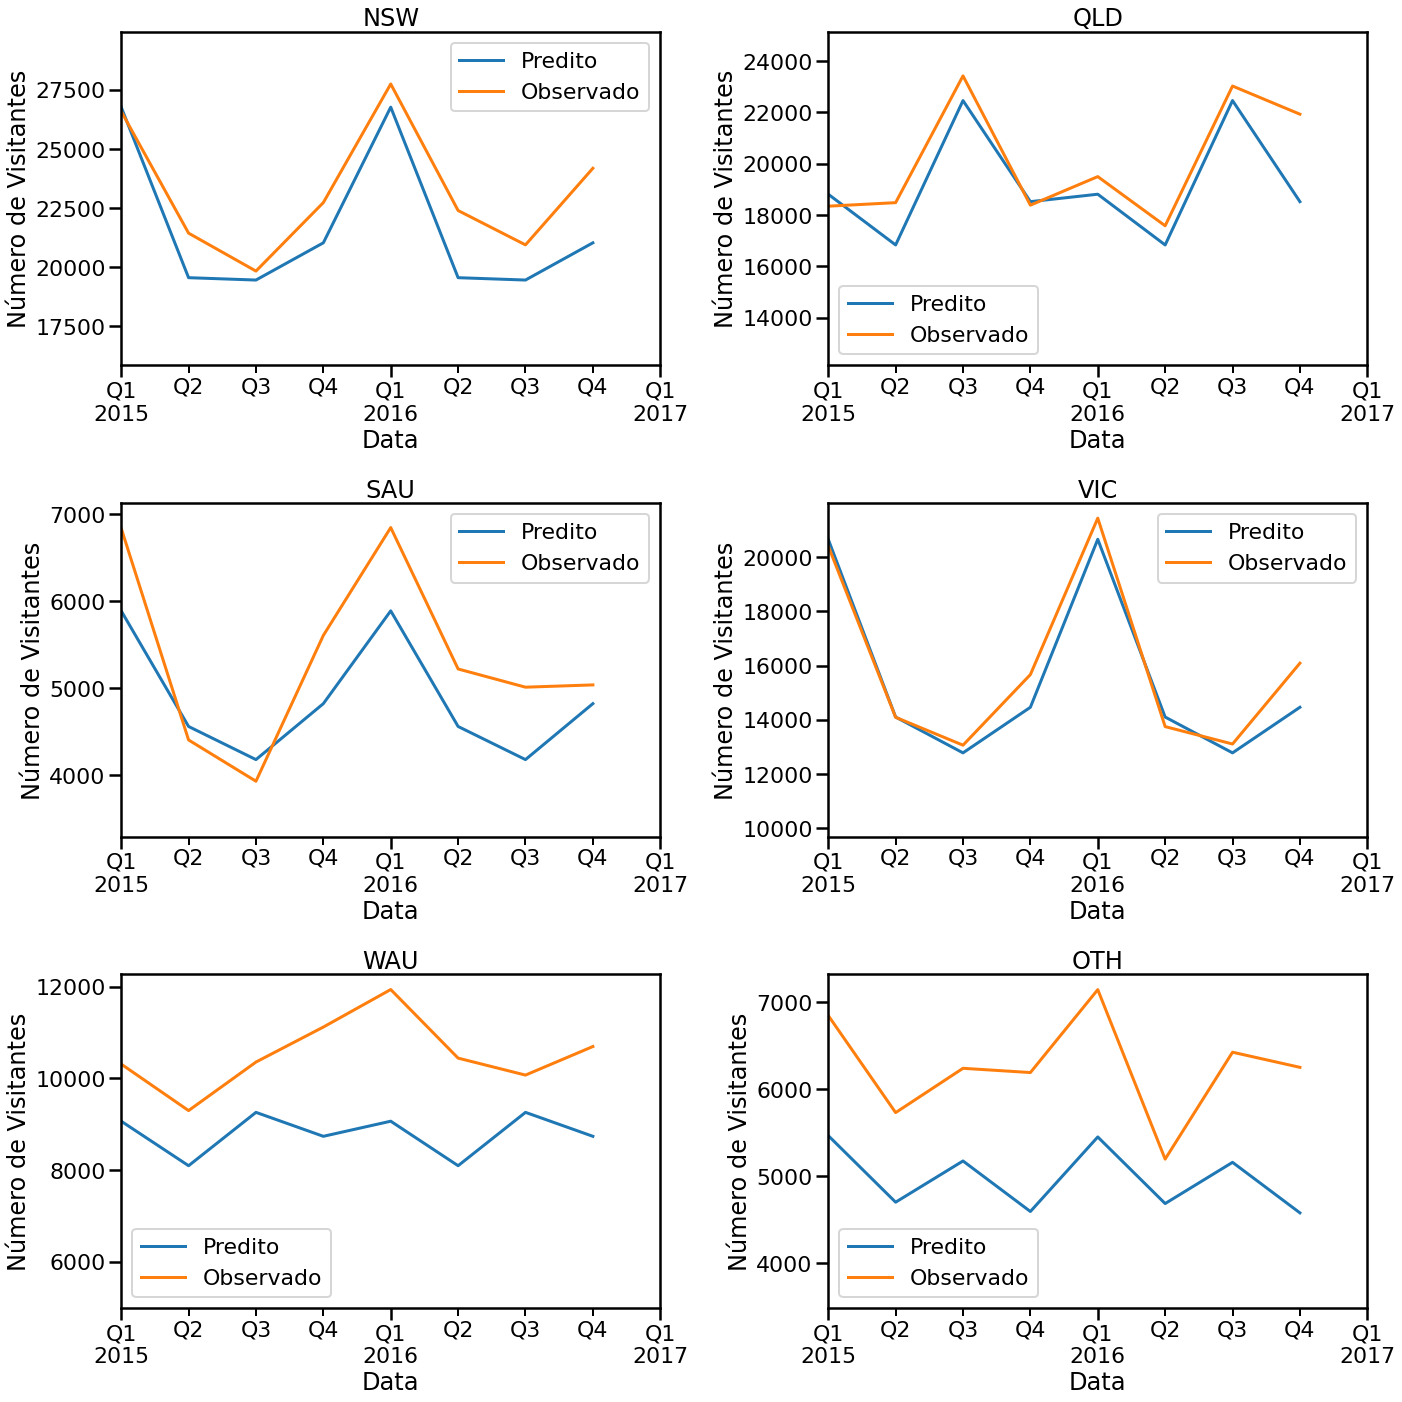

In [210]:
fig, axes = plt.subplots(3, 2, figsize=(20, 20), sharey=False)

def plot_results(cols, axes, preds):
    
    preds = preds.set_index(visnights_bottom_level.iloc[-test.shape[0]:].index)
    axes = np.hstack(axes)
    for ax, col in zip(axes, cols):
        preds[col].plot(ax=ax, label="Predito")
        visnights_bottom_level[col].plot(ax=ax, label="Observado")

        ax.legend()
        ax.set_title(col)
        ax.set_xlabel("Data")
        ax.set_ylabel("Número de Visitantes")
        ax.set_xlim('2015', '2017')


plot_results(states, axes, pred_revised_ets_bu)
plt.tight_layout()
plt

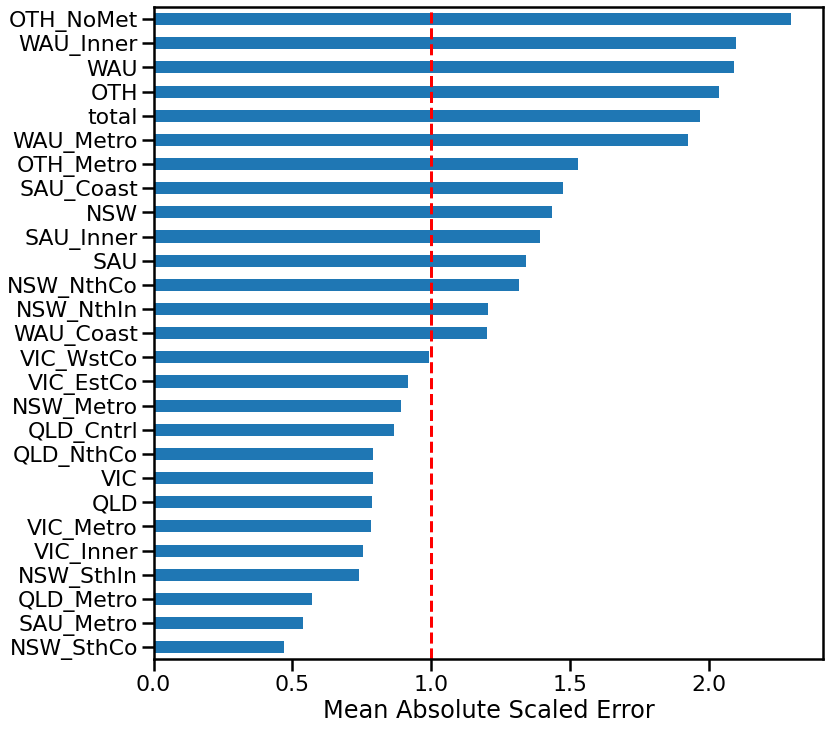

In [211]:
from sklearn.metrics import mean_absolute_error
from pmdarima.metrics import smape
from metrics import mean_absolute_scaled_error

def plot_mase_error(train, test, pred):

    ax = (
        mean_absolute_scaled_error(
            test.reset_index(drop=True), 
            pred.reset_index(drop=True), 
            train, 
            m=4)
        .sort_values()
        .plot(kind='barh', figsize=(12, 12))
    )

    ax.axvline(x=1, linestyle='--', color='red')
    ax.set_xlabel("Mean Absolute Scaled Error")
    
plot_mase_error(train_val, test, pred_revised_ets_bu)

In [212]:
mase = list()
total_metrics = dict()

def collect_metrics(train, test, pred, name):
    mase.append(
        mean_absolute_scaled_error(
            test.reset_index(drop=True), 
            pred.reset_index(drop=True), 
            train,m=4)
    )
    
    total_metrics[name] = dict(
    mae=np.round(mean_absolute_error(test['total'], pred['total']), 2),
    smape=np.round(smape(test['total'], pred['total']), 2),
    mase=mean_absolute_scaled_error(
            test.reset_index(drop=True), 
            pred.reset_index(drop=True), 
            train,
            m=4
        )['total']
    )

collect_metrics(train_val, test, pred_revised_ets_bu, name='ets_bu')
total_metrics

{'ets_bu': {'mae': 6426.76, 'smape': 8.28, 'mase': 1.9668334782452996}}

#### Optimal Combination (OLS)

In [213]:
pred_revised_ets_ols = ets_model.predict_revised(sum_mat, method='OLS', ht=ht, yhat_columns=test.columns.tolist())

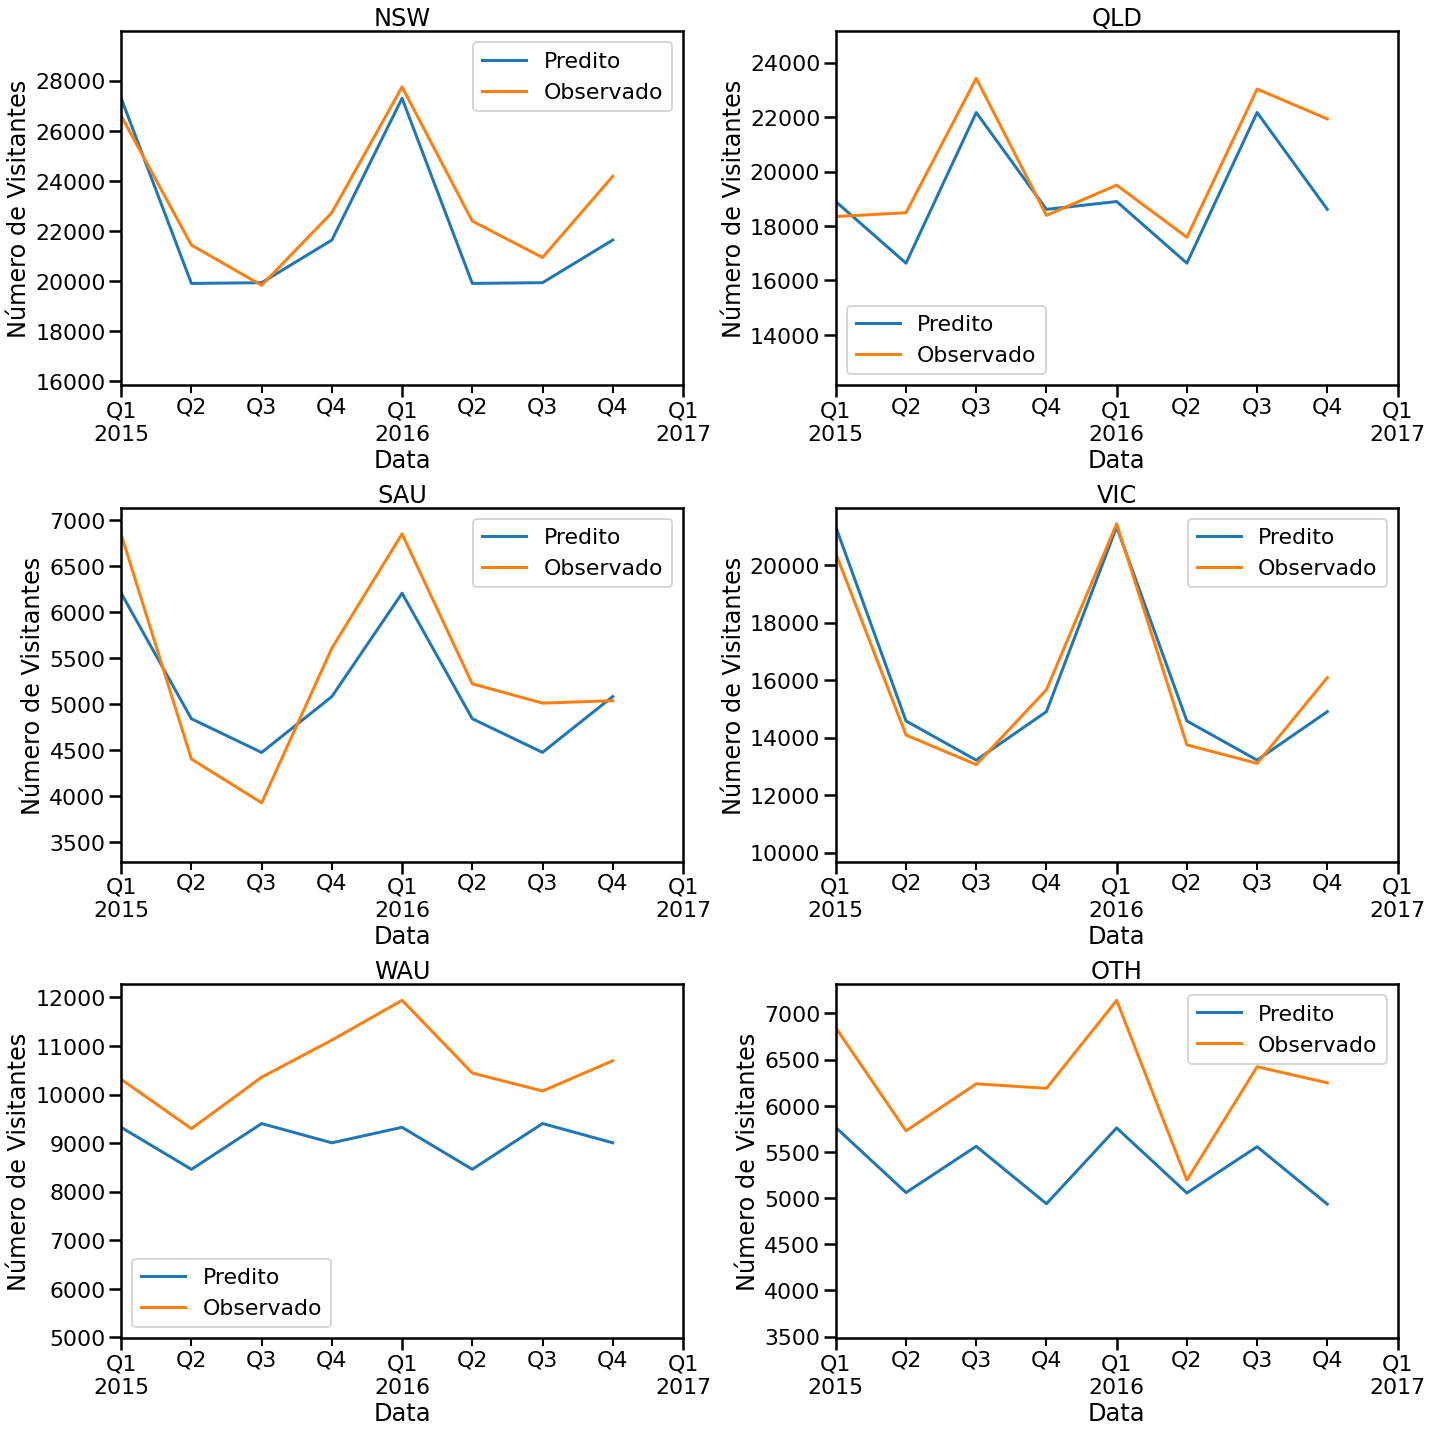

In [268]:
fig, axes = plt.subplots(3, 2, figsize=(20, 20), sharey=False)

plot_results(states, axes, pred_revised_ets_ols)
plt.tight_layout()

plt.savefig('ets_ols_visnights_states.png')

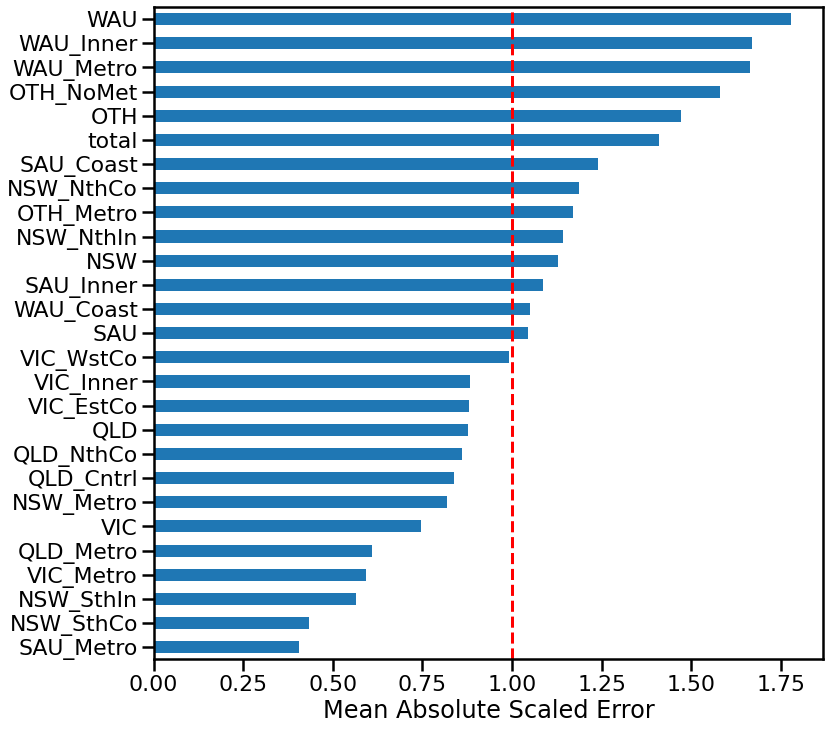

In [269]:
plot_mase_error(train_val, test, pred_revised_ets_ols)
plt.savefig('mase_ets_ols.png')

In [216]:
collect_metrics(train_val, test, pred_revised_ets_ols, name='ets_ols')
total_metrics

{'ets_bu': {'mae': 6426.76, 'smape': 8.28, 'mase': 1.9668334782452996},
 'ets_ols': {'mae': 4604.64, 'smape': 5.89, 'mase': 1.4091947983236526}}

#### Top-Down

In [217]:
pred_revised_ets_td = ets_model.predict_revised(sum_mat, method='AHP', ht=ht, yhat_columns=test.columns.tolist())
pred_revised_ets_td = pred_revised_ets_td*10

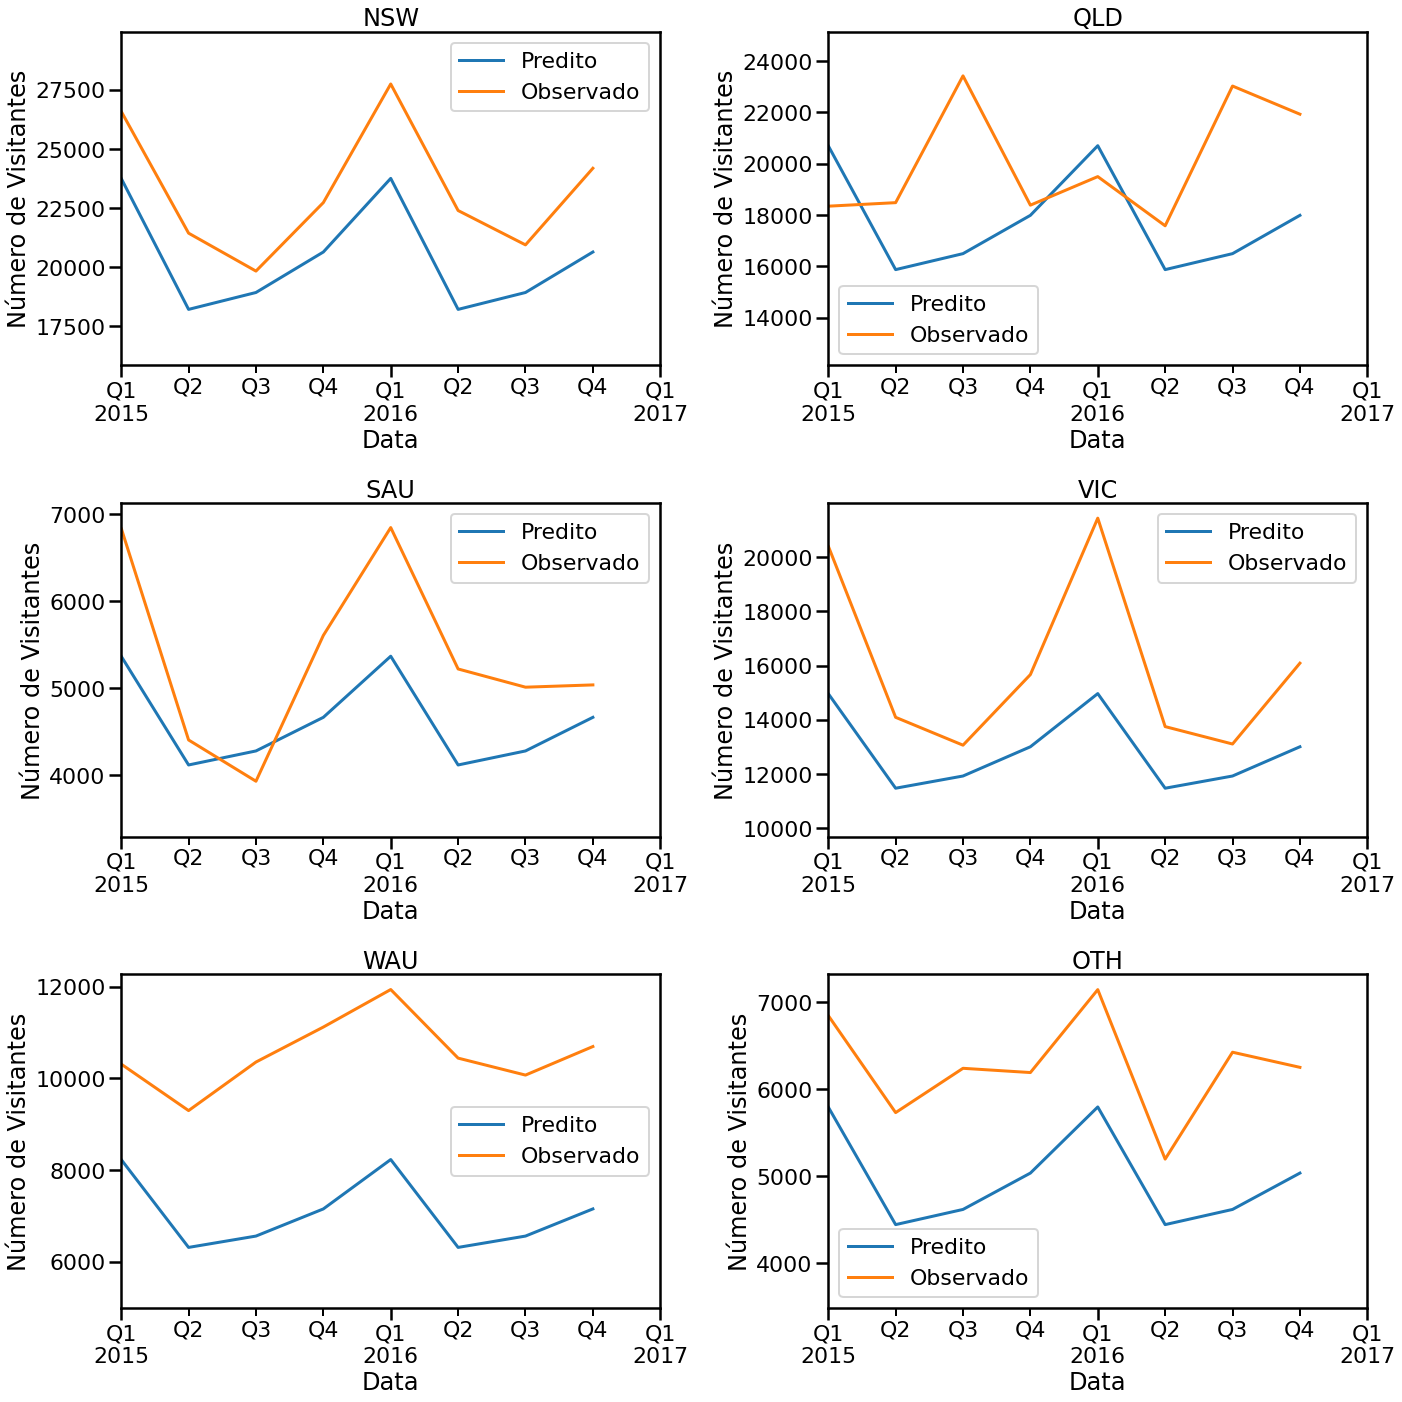

In [218]:
fig, axes = plt.subplots(3, 2, figsize=(20, 20), sharey=False)

plot_results(states, axes, pred_revised_ets_td)
plt.tight_layout()

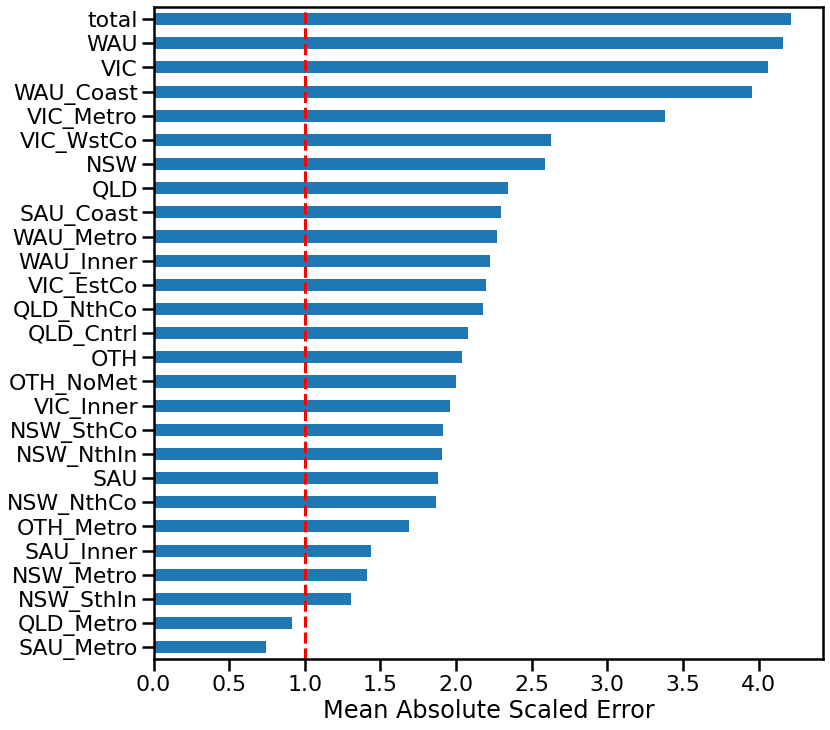

In [219]:
plot_mase_error(train_val, test, pred_revised_ets_td)

In [220]:
collect_metrics(train_val, test, pred_revised_ets_td, name='ets_td')
total_metrics

{'ets_bu': {'mae': 6426.76, 'smape': 8.28, 'mase': 1.9668334782452996},
 'ets_ols': {'mae': 4604.64, 'smape': 5.89, 'mase': 1.4091947983236526},
 'ets_td': {'mae': 13778.68, 'smape': 18.66, 'mase': 4.2168002464599095}}

### ARIMA

#### Bottom-Up

In [221]:
from sktime.forecasting.arima import AutoARIMA

arima = AutoARIMA(sp=4, suppress_warnings=True)

arima_model = HierarchicalModel(model=arima, nodes=nodes)
arima_model.fit(train_val, test)

In [222]:
pred_revised_arima_bu = arima_model.predict_revised(sum_mat, method='BU', ht=ht, yhat_columns=bottom_level)

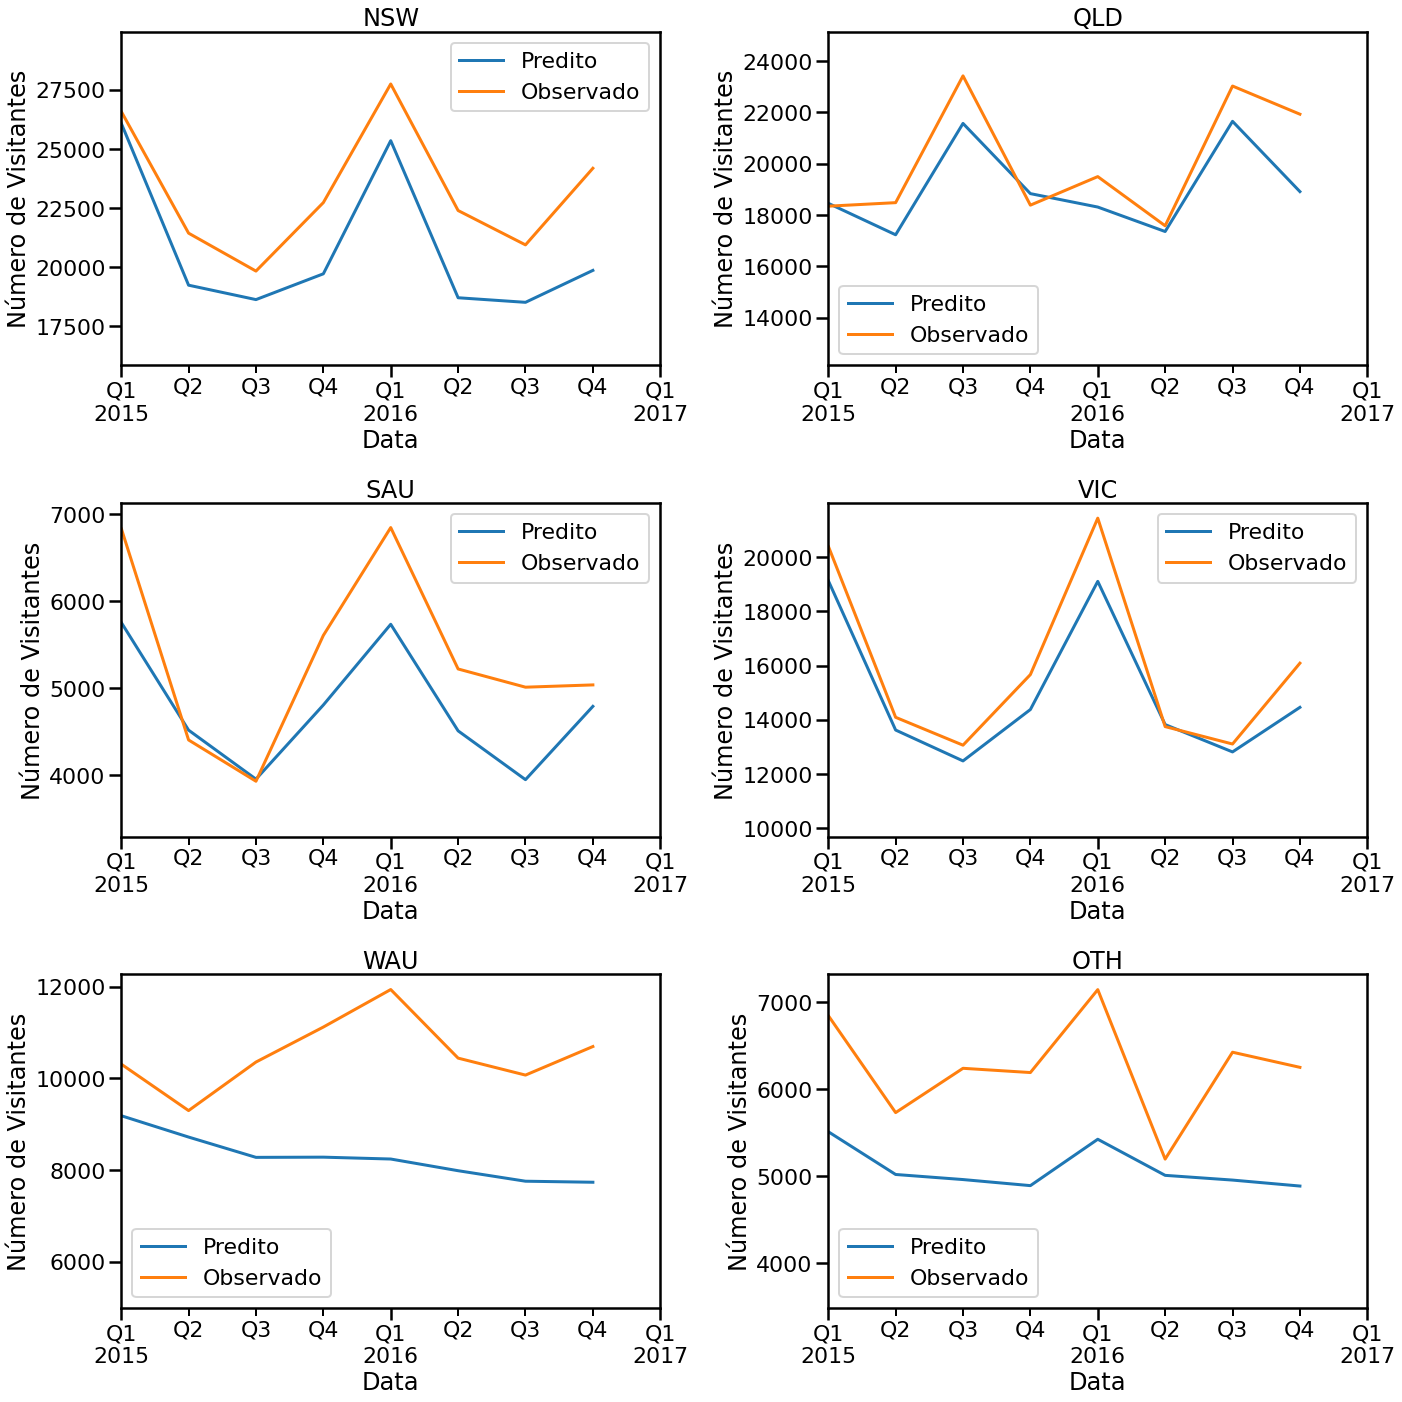

In [223]:
fig, axes = plt.subplots(3, 2, figsize=(20, 20), sharey=False)

plot_results(states, axes, pred_revised_arima_bu)
plt.tight_layout()

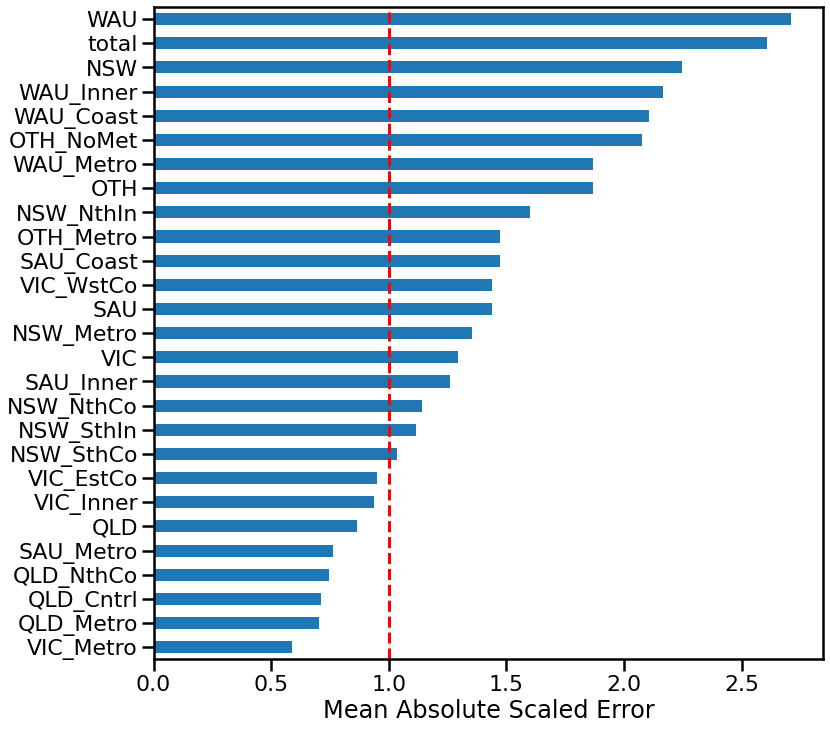

In [224]:
plot_mase_error(train_val, test, pred_revised_arima_bu)

In [225]:
collect_metrics(train_val, test, pred_revised_arima_bu, name='arima_bu')
total_metrics

{'ets_bu': {'mae': 6426.76, 'smape': 8.28, 'mase': 1.9668334782452996},
 'ets_ols': {'mae': 4604.64, 'smape': 5.89, 'mase': 1.4091947983236526},
 'ets_td': {'mae': 13778.68, 'smape': 18.66, 'mase': 4.2168002464599095},
 'arima_bu': {'mae': 8524.06, 'smape': 11.02, 'mase': 2.6086865861276927}}

#### Optimal Combination

In [226]:
pred_revised_arima_ols = arima_model.predict_revised(sum_mat, method='OLS', ht=ht, yhat_columns=test.columns.tolist())

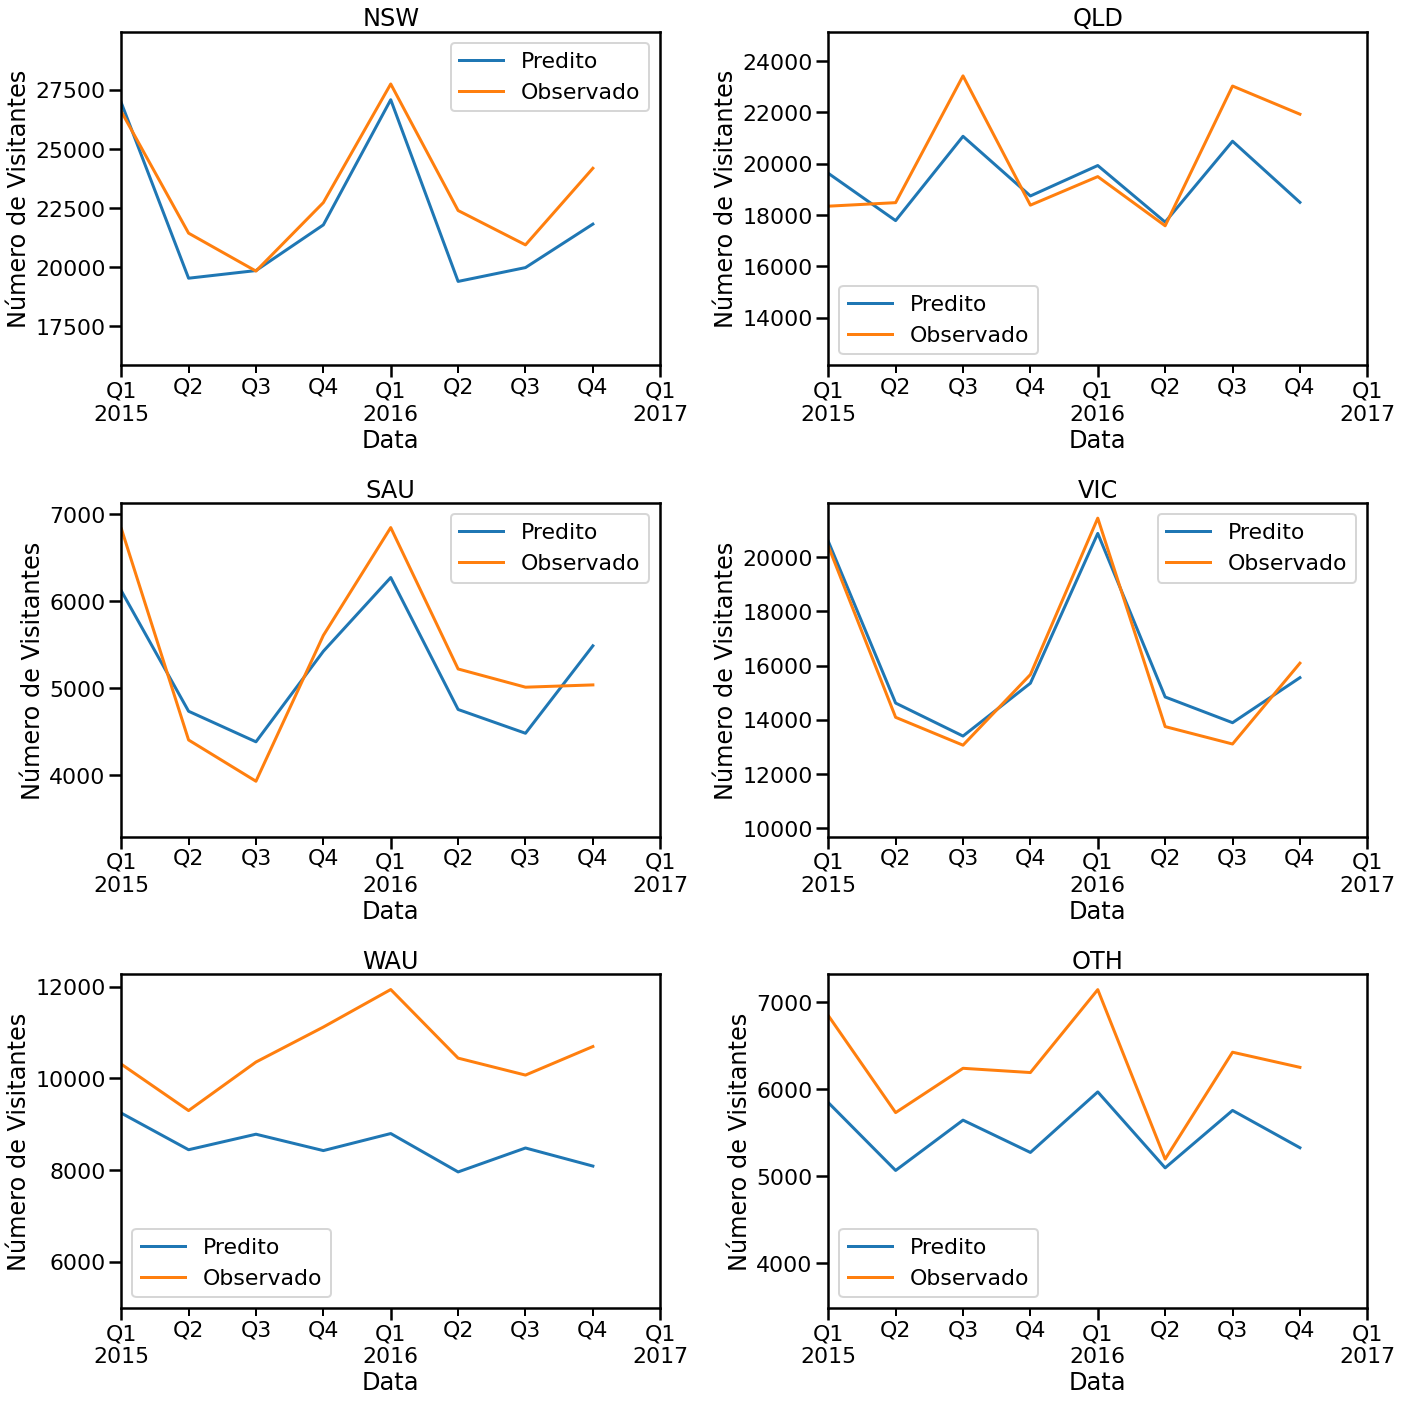

In [227]:
fig, axes = plt.subplots(3, 2, figsize=(20, 20), sharey=False)

plot_results(states, axes, pred_revised_arima_ols)
plt.tight_layout()

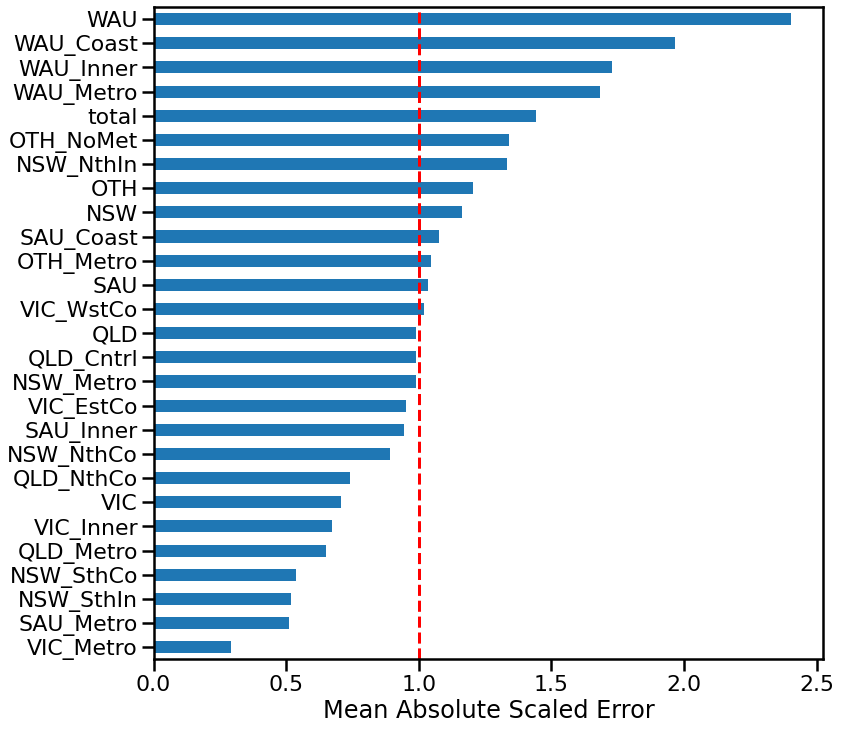

In [228]:
plot_mase_error(train_val, test, pred_revised_arima_ols)

In [229]:
collect_metrics(train_val, test, pred_revised_arima_ols, name='arima_ols')
total_metrics

{'ets_bu': {'mae': 6426.76, 'smape': 8.28, 'mase': 1.9668334782452996},
 'ets_ols': {'mae': 4604.64, 'smape': 5.89, 'mase': 1.4091947983236526},
 'ets_td': {'mae': 13778.68, 'smape': 18.66, 'mase': 4.2168002464599095},
 'arima_bu': {'mae': 8524.06, 'smape': 11.02, 'mase': 2.6086865861276927},
 'arima_ols': {'mae': 4709.05, 'smape': 6.01, 'mase': 1.4411478236423094}}

#### Top-Down

In [230]:
pred_revised_arima_td = arima_model.predict_revised(sum_mat, method='AHP', ht=ht, yhat_columns=test.columns.tolist())
pred_revised_arima_td = pred_revised_arima_td*10

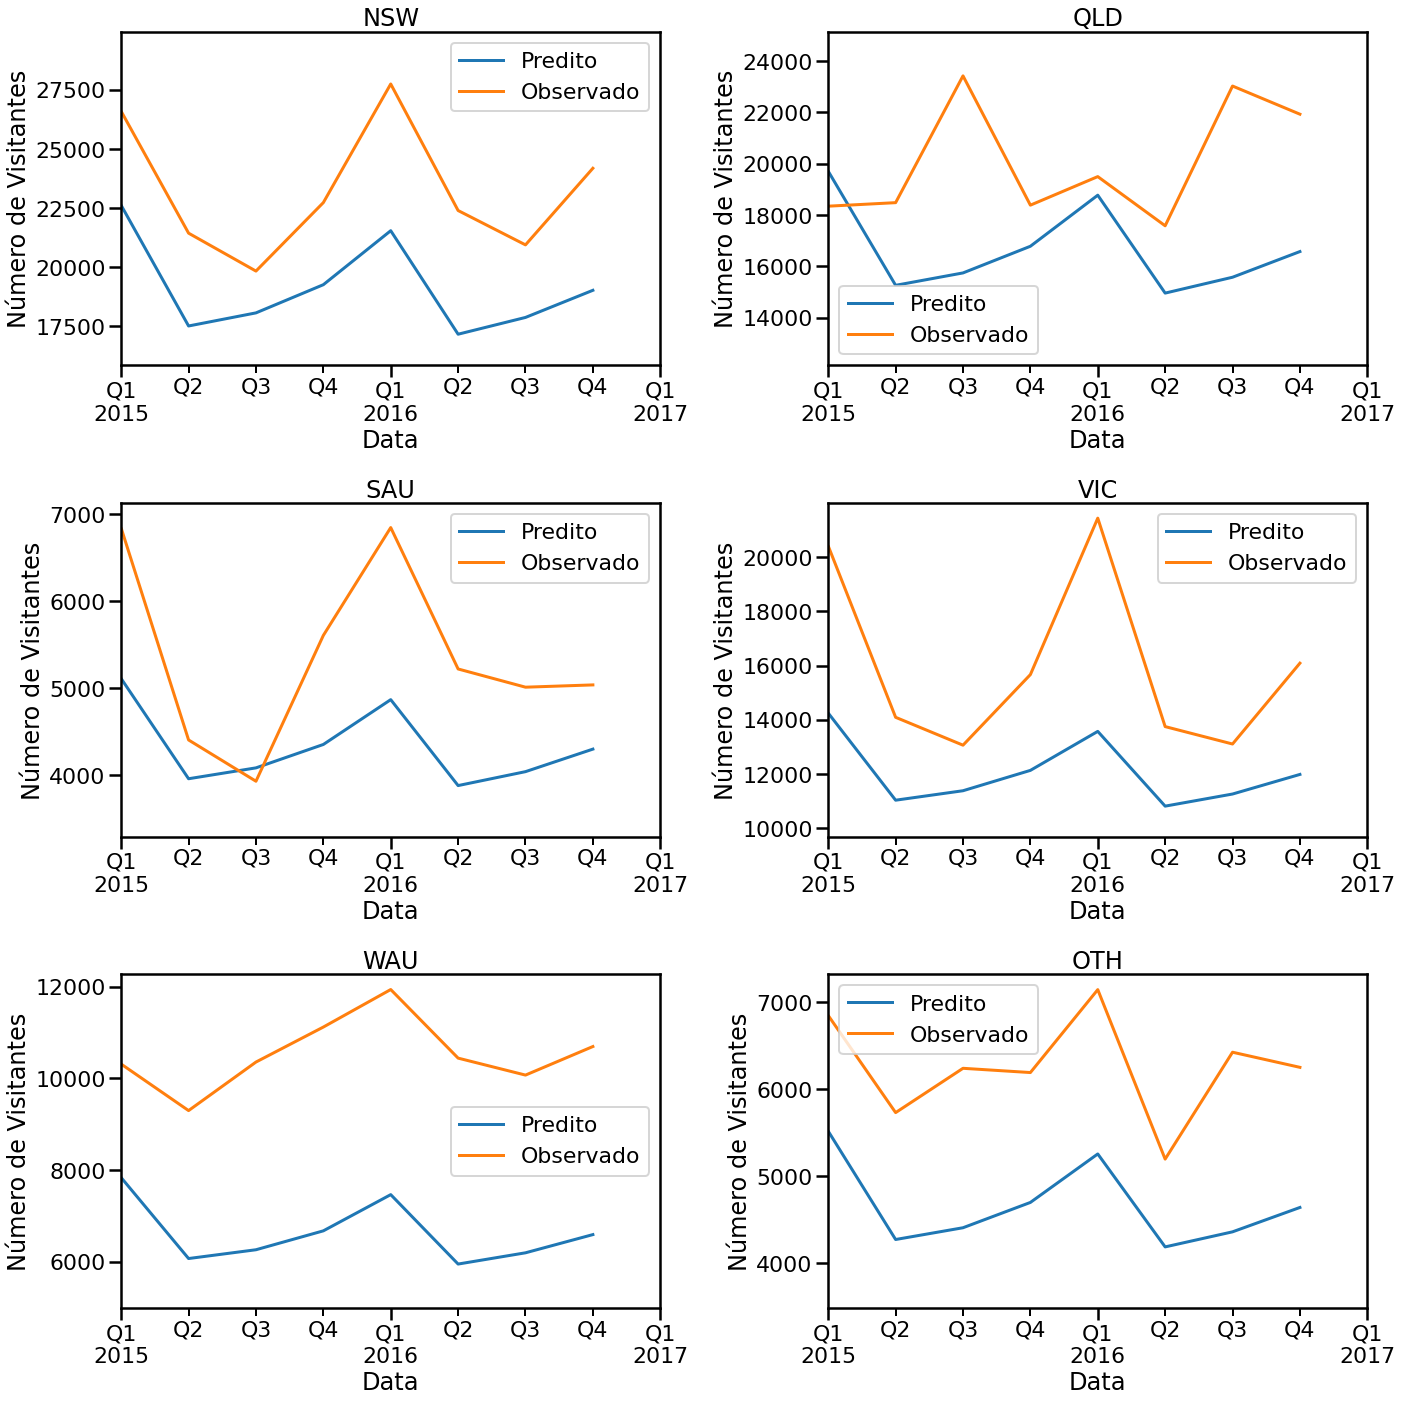

In [231]:
fig, axes = plt.subplots(3, 2, figsize=(20, 20), sharey=False)

plot_results(states, axes, pred_revised_arima_td)
plt.tight_layout()

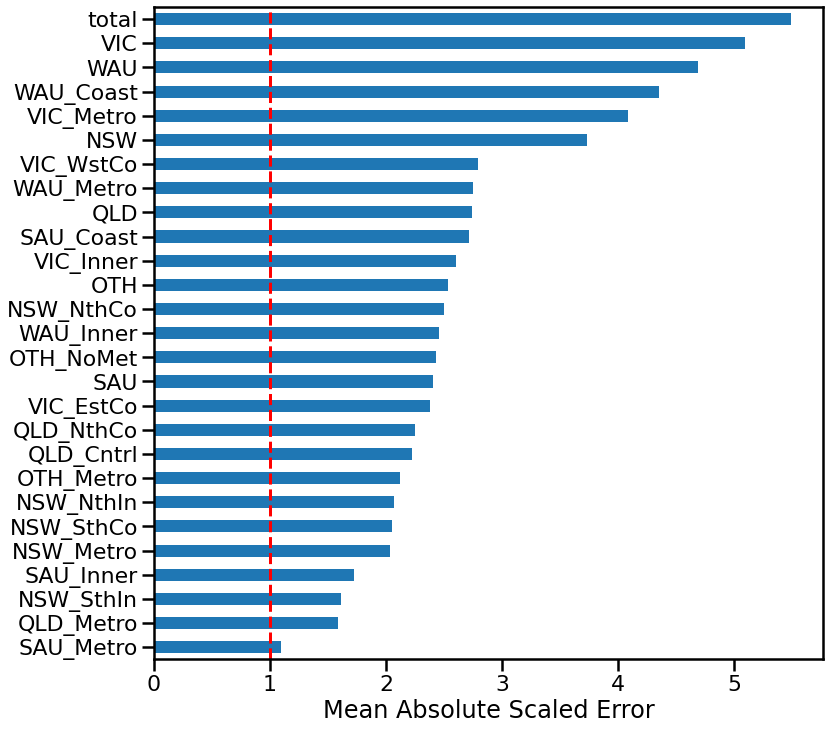

In [232]:
plot_mase_error(train_val, test, pred_revised_arima_td)

In [233]:
collect_metrics(train_val, test, pred_revised_arima_td, name='arima_td')
total_metrics

{'ets_bu': {'mae': 6426.76, 'smape': 8.28, 'mase': 1.9668334782452996},
 'ets_ols': {'mae': 4604.64, 'smape': 5.89, 'mase': 1.4091947983236526},
 'ets_td': {'mae': 13778.68, 'smape': 18.66, 'mase': 4.2168002464599095},
 'arima_bu': {'mae': 8524.06, 'smape': 11.02, 'mase': 2.6086865861276927},
 'arima_ols': {'mae': 4709.05, 'smape': 6.01, 'mase': 1.4411478236423094},
 'arima_td': {'mae': 17935.18, 'smape': 24.84, 'mase': 5.488847281432838}}

### Random Forests

In [175]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sktime.utils.plotting import plot_series
from sktime.forecasting.model_selection import (
    ForecastingGridSearchCV,
    SlidingWindowSplitter,
    temporal_train_test_split,
)

from sktime.forecasting.compose import (
    EnsembleForecaster,
    ReducedRegressionForecaster,
    TransformedTargetForecaster,
)

fh = np.arange(len(test)) + 1
fh

# tuning the 'n_estimator' hyperparameter of RandomForestRegressor from scikit-learn
regressor_param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 5, 7, None],
    "criterion": ["mae"],
    "max_features": [0.5, 0.8, 1],
    }
forecaster_param_grid = {"window_length": [15, 20, 28, 56, 70]}

# create a tunnable regressor with GridSearchCV
regressor = GridSearchCV(RandomForestRegressor(), param_grid=regressor_param_grid)
rf_forecaster = ReducedRegressionForecaster(
    regressor, window_length=15, strategy="recursive"
)

cv = SlidingWindowSplitter(initial_window=int(len(train_val) * 0.5))
gscv = ForecastingGridSearchCV(rf_forecaster, cv=cv, param_grid=forecaster_param_grid)

gscv.fit(train_val['total'])

ForecastingGridSearchCV(cv=<sktime.forecasting.model_selection._split.SlidingWindowSplitter object at 0x7fa9981e5f40>,
                        forecaster=RecursiveRegressionForecaster(regressor=GridSearchCV(estimator=RandomForestRegressor(),
                                                                                        param_grid={'criterion': ['mae'],
                                                                                                    'max_depth': [3,
                                                                                                                  5,
                                                                                                                  7,
                                                                                                                  None],
                                                                                                    'max_features': [0.5,
                                          

In [176]:
# from sktime.transformers.single_series.detrend import Deseasonalizer, Detrender


# rf_forecaster = TransformedTargetForecaster(
#     [
#        ("deseasonalise", Deseasonalizer(model="additive", sp=4)),
#        #("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
#        (
#            "forecast",
#            ReducedRegressionForecaster(
#                regressor=regressor, window_length=gscv.best_params_['window_length'], strategy="recursive"
#  #          ),
#        ),
#    ]
#)

In [238]:
regressor = RandomForestRegressor()

rf_forecaster = ReducedRegressionForecaster(
    regressor, window_length=gscv.best_params_['window_length'], strategy="recursive"
)

#### Bottom-Up

In [240]:
rf_model = HierarchicalModel(model=rf_forecaster, nodes=nodes)
rf_model.fit(train_val, test)

In [241]:
pred_revised_rf_bu = rf_model.predict_revised(sum_mat, method='BU', ht=ht, yhat_columns=bottom_level)

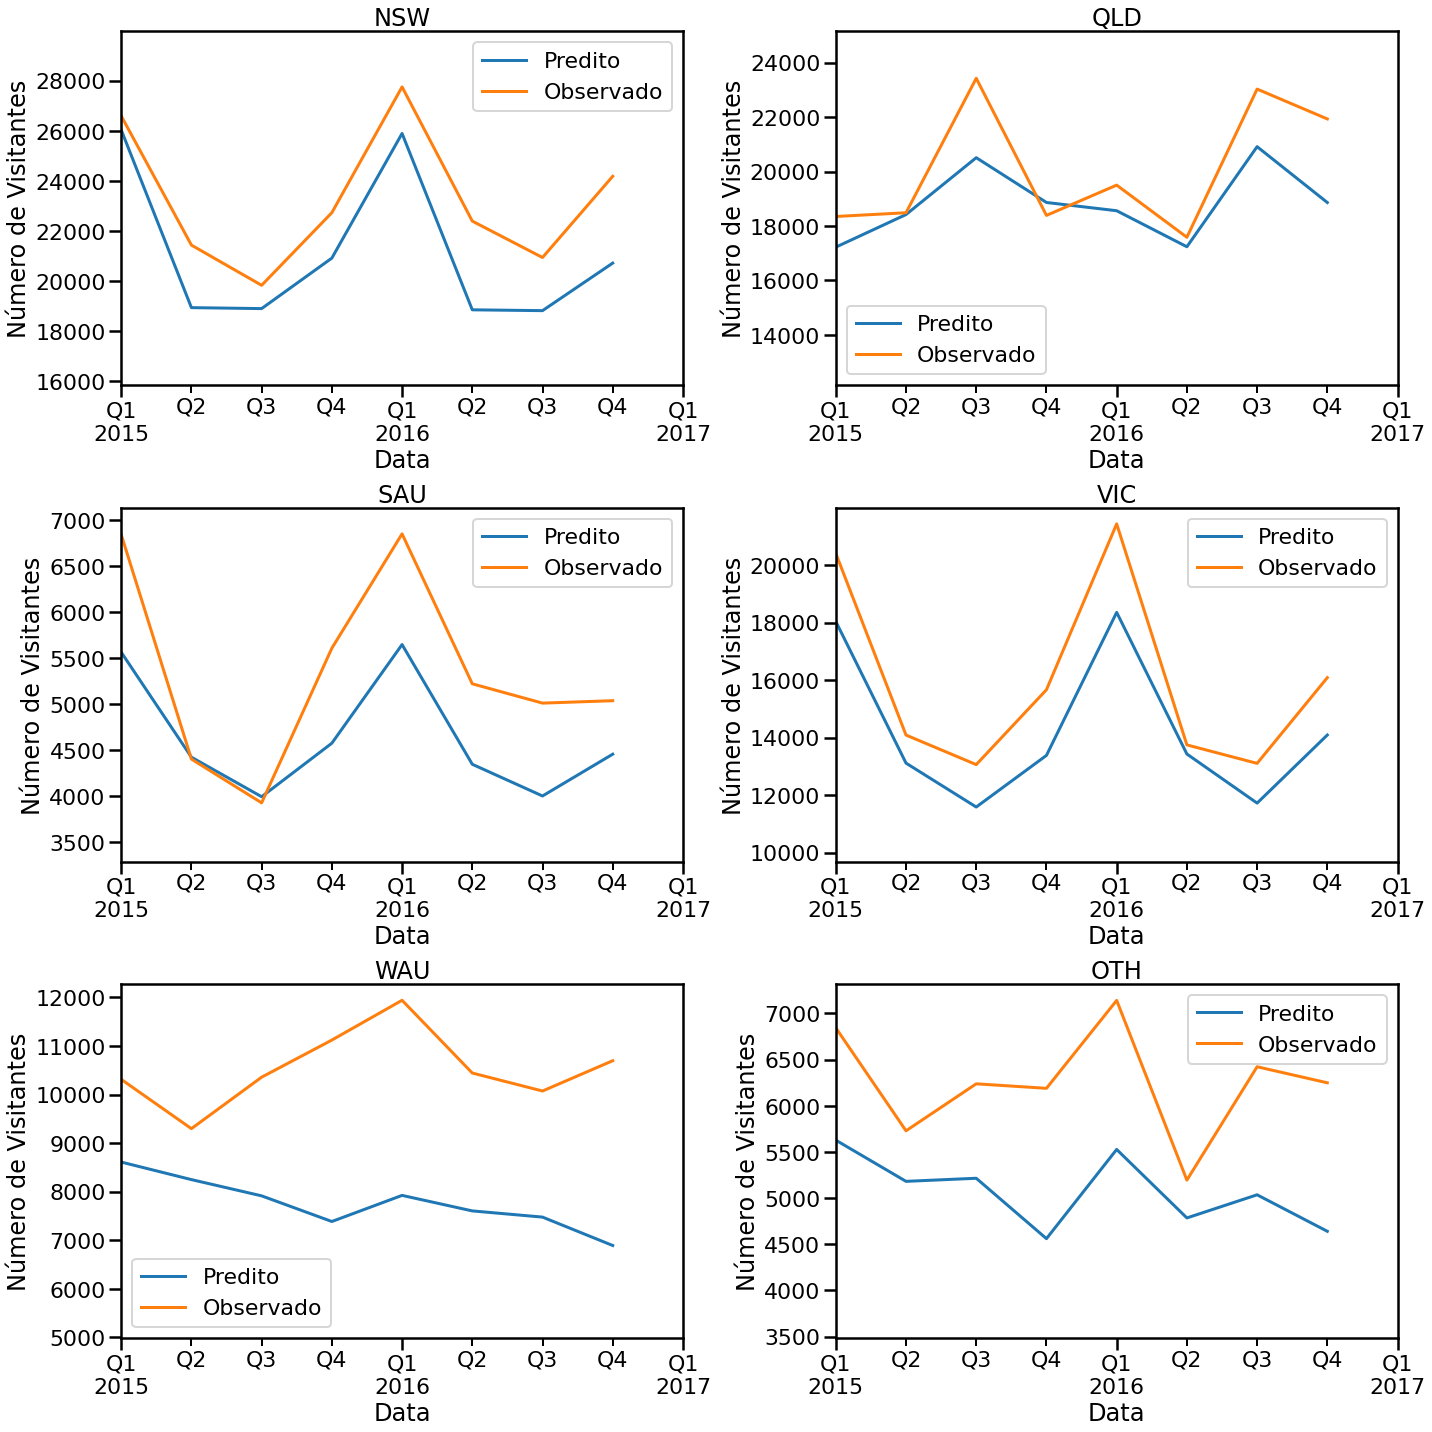

In [242]:
fig, axes = plt.subplots(3, 2, figsize=(20, 20), sharey=False)

plot_results(states, axes, pred_revised_rf_bu)
plt.tight_layout()

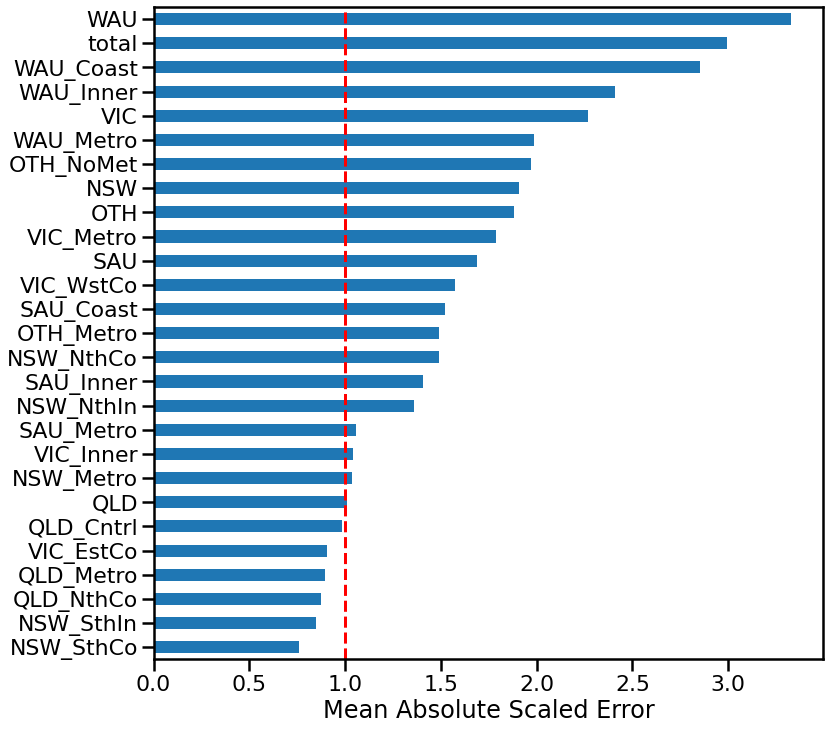

In [243]:
plot_mase_error(train_val, test, pred_revised_rf_bu)

In [244]:
collect_metrics(train_val, test, pred_revised_rf_bu, name='rf_bu')
total_metrics

{'ets_bu': {'mae': 6426.76, 'smape': 8.28, 'mase': 1.9668334782452996},
 'ets_ols': {'mae': 4604.64, 'smape': 5.89, 'mase': 1.4091947983236526},
 'ets_td': {'mae': 13778.68, 'smape': 18.66, 'mase': 4.2168002464599095},
 'arima_bu': {'mae': 8524.06, 'smape': 11.02, 'mase': 2.6086865861276927},
 'arima_ols': {'mae': 4709.05, 'smape': 6.01, 'mase': 1.4411478236423094},
 'arima_td': {'mae': 17935.18, 'smape': 24.84, 'mase': 5.488847281432838},
 'rf_bu': {'mae': 9782.98, 'smape': 12.74, 'mase': 2.9939642173877896}}

#### Optimal Combination

In [245]:
pred_revised_rf_ols = rf_model.predict_revised(sum_mat, method='OLS', ht=ht, yhat_columns=test.columns.tolist())

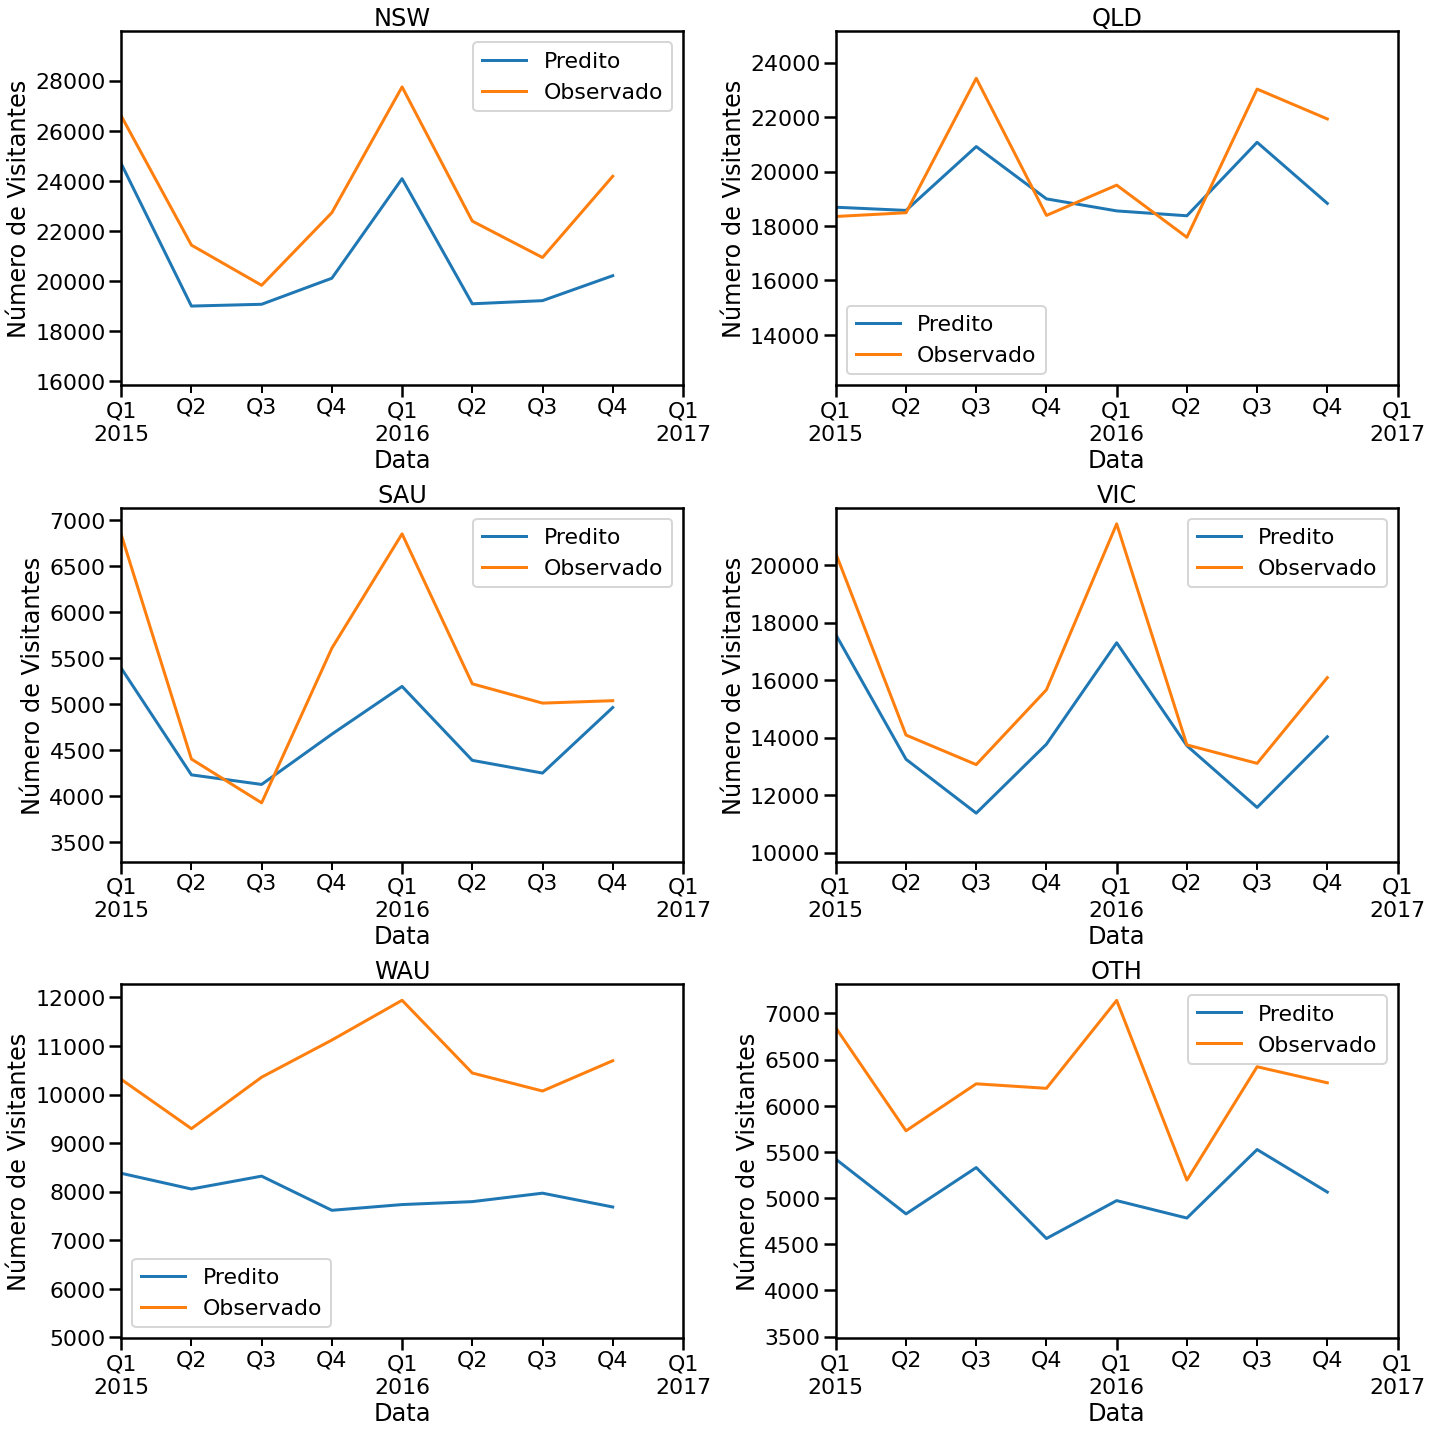

In [246]:
fig, axes = plt.subplots(3, 2, figsize=(20, 20), sharey=False)

plot_results(states, axes, pred_revised_rf_ols)
plt.tight_layout()

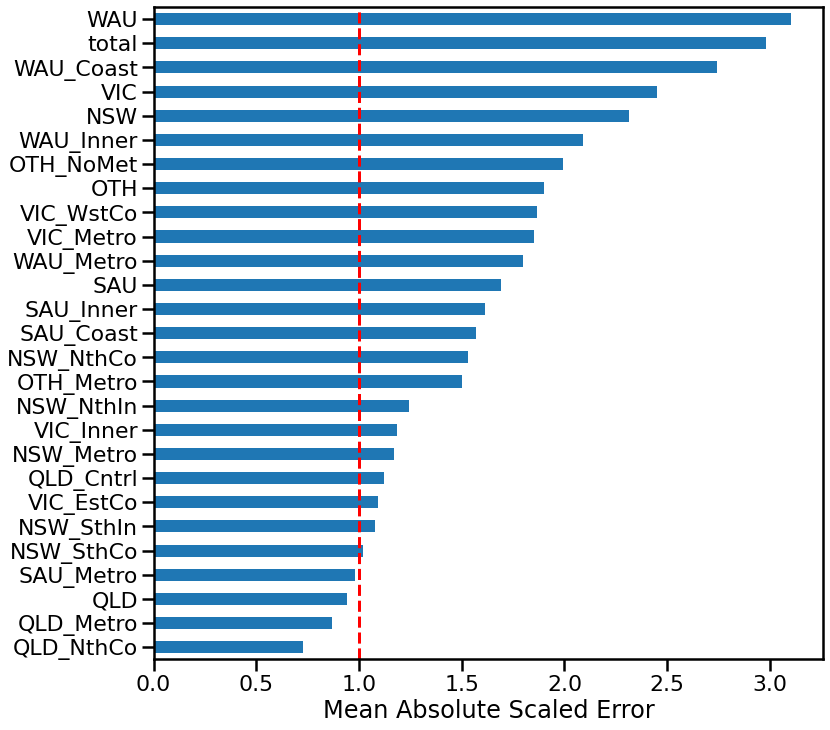

In [247]:
plot_mase_error(train_val, test, pred_revised_rf_ols)

In [248]:
collect_metrics(train_val, test, pred_revised_rf_ols, name='rf_ols')
total_metrics

{'ets_bu': {'mae': 6426.76, 'smape': 8.28, 'mase': 1.9668334782452996},
 'ets_ols': {'mae': 4604.64, 'smape': 5.89, 'mase': 1.4091947983236526},
 'ets_td': {'mae': 13778.68, 'smape': 18.66, 'mase': 4.2168002464599095},
 'arima_bu': {'mae': 8524.06, 'smape': 11.02, 'mase': 2.6086865861276927},
 'arima_ols': {'mae': 4709.05, 'smape': 6.01, 'mase': 1.4411478236423094},
 'arima_td': {'mae': 17935.18, 'smape': 24.84, 'mase': 5.488847281432838},
 'rf_bu': {'mae': 9782.98, 'smape': 12.74, 'mase': 2.9939642173877896},
 'rf_ols': {'mae': 9740.69, 'smape': 12.55, 'mase': 2.981021491909413}}

#### Top-Down

In [249]:
pred_revised_rf_td = rf_model.predict_revised(sum_mat, method='AHP', ht=ht, yhat_columns=test.columns.tolist())
pred_revised_rf_td = pred_revised_rf_td*10

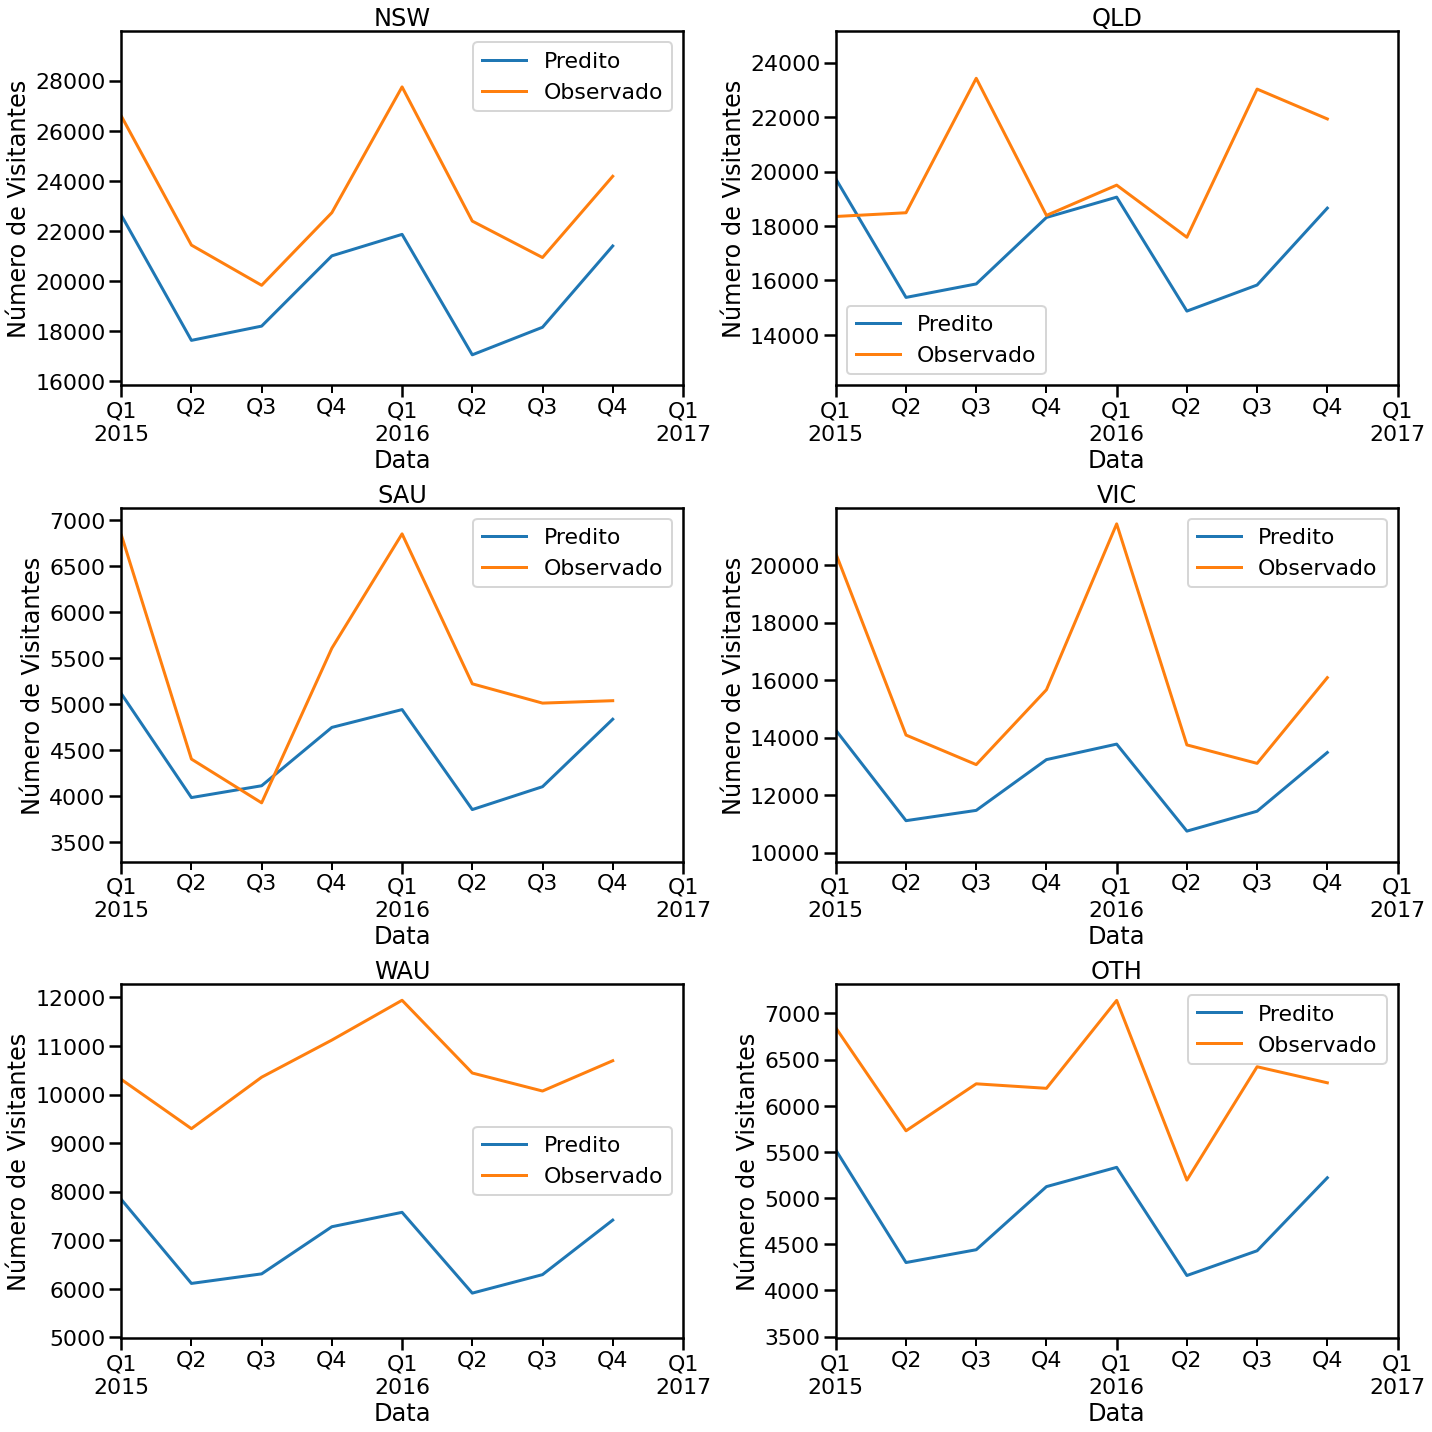

In [250]:
fig, axes = plt.subplots(3, 2, figsize=(20, 20), sharey=False)

plot_results(states, axes, pred_revised_rf_td)
plt.tight_layout()

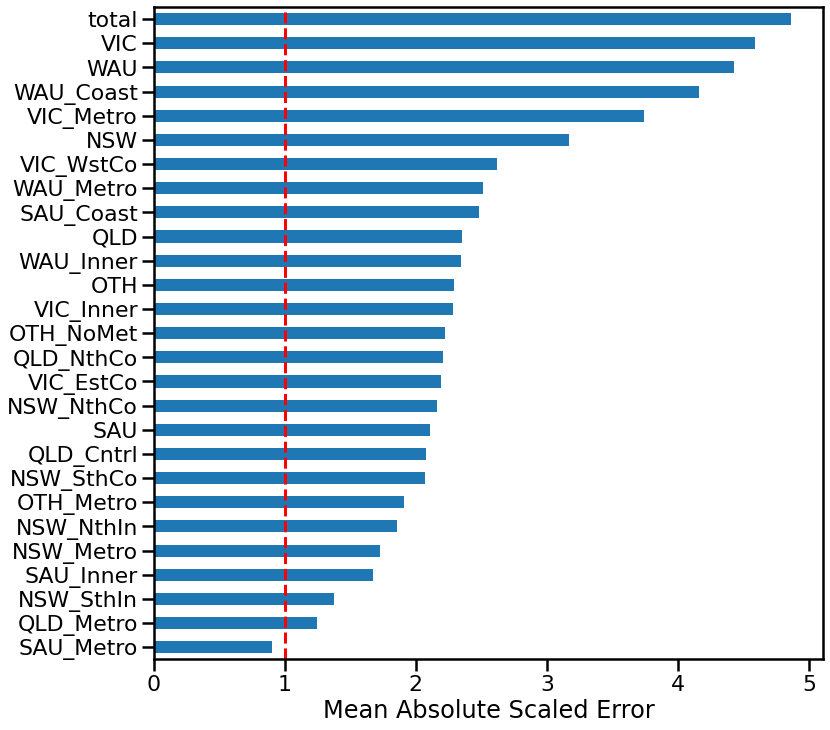

In [251]:
plot_mase_error(train_val, test, pred_revised_rf_td)

In [252]:
collect_metrics(train_val, test, pred_revised_rf_td, name='rf_td')
total_metrics

{'ets_bu': {'mae': 6426.76, 'smape': 8.28, 'mase': 1.9668334782452996},
 'ets_ols': {'mae': 4604.64, 'smape': 5.89, 'mase': 1.4091947983236526},
 'ets_td': {'mae': 13778.68, 'smape': 18.66, 'mase': 4.2168002464599095},
 'arima_bu': {'mae': 8524.06, 'smape': 11.02, 'mase': 2.6086865861276927},
 'arima_ols': {'mae': 4709.05, 'smape': 6.01, 'mase': 1.4411478236423094},
 'arima_td': {'mae': 17935.18, 'smape': 24.84, 'mase': 5.488847281432838},
 'rf_bu': {'mae': 9782.98, 'smape': 12.74, 'mase': 2.9939642173877896},
 'rf_ols': {'mae': 9740.69, 'smape': 12.55, 'mase': 2.981021491909413},
 'rf_td': {'mae': 15890.67, 'smape': 21.8, 'mase': 4.863150286999006}}

### Gradient Boosting

In [192]:
from sklearn.ensemble import GradientBoostingRegressor

regressor_param_grid = {
    "learning_rate": [0.01, 0.5, 0.1],
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 5, 7, None],
    "max_features": [0.5, 0.7, 1],
    "loss": ["lad"],
    "criterion": ["mae"],
    "subsample": [0.5, 0.8, 1],
    }

forecaster_param_grid = {"window_length": [15, 20, 28, 56, 70]}

# create a tunnable regressor with GridSearchCV
regressor = GridSearchCV(GradientBoostingRegressor(), param_grid=regressor_param_grid)

gb_forecaster = ReducedRegressionForecaster(
    regressor, window_length=15, strategy="recursive"
)

cv = SlidingWindowSplitter(initial_window=int(len(train_val) * 0.5))
gscv = ForecastingGridSearchCV(gb_forecaster, cv=cv, param_grid=forecaster_param_grid)

gscv.fit(train_val['total'])

ForecastingGridSearchCV(cv=<sktime.forecasting.model_selection._split.SlidingWindowSplitter object at 0x7fa981412d30>,
                        forecaster=RecursiveRegressionForecaster(regressor=GridSearchCV(estimator=GradientBoostingRegressor(),
                                                                                        param_grid={'criterion': ['mae'],
                                                                                                    'learning_rate': [0.01,
                                                                                                                      0.5,
                                                                                                                      0.1],
                                                                                                    'loss': ['lad'],
                                                                                                    'max_depth': [3,
                           

#### Bottom-Up

In [253]:
from sklearn.ensemble import GradientBoostingRegressor

regressor_gb = GradientBoostingRegressor(**gscv.best_forecaster_.regressor_.best_params_)
gb_forecaster =  ReducedRegressionForecaster(
    regressor_gb, window_length=gscv.best_params_['window_length'], strategy="recursive"
)

In [254]:
gb_model = HierarchicalModel(model=gb_forecaster, nodes=nodes)
gb_model.fit(train_val, test)

In [255]:
pred_revised_gb_bu = gb_model.predict_revised(sum_mat, method='BU', ht=ht, yhat_columns=bottom_level)

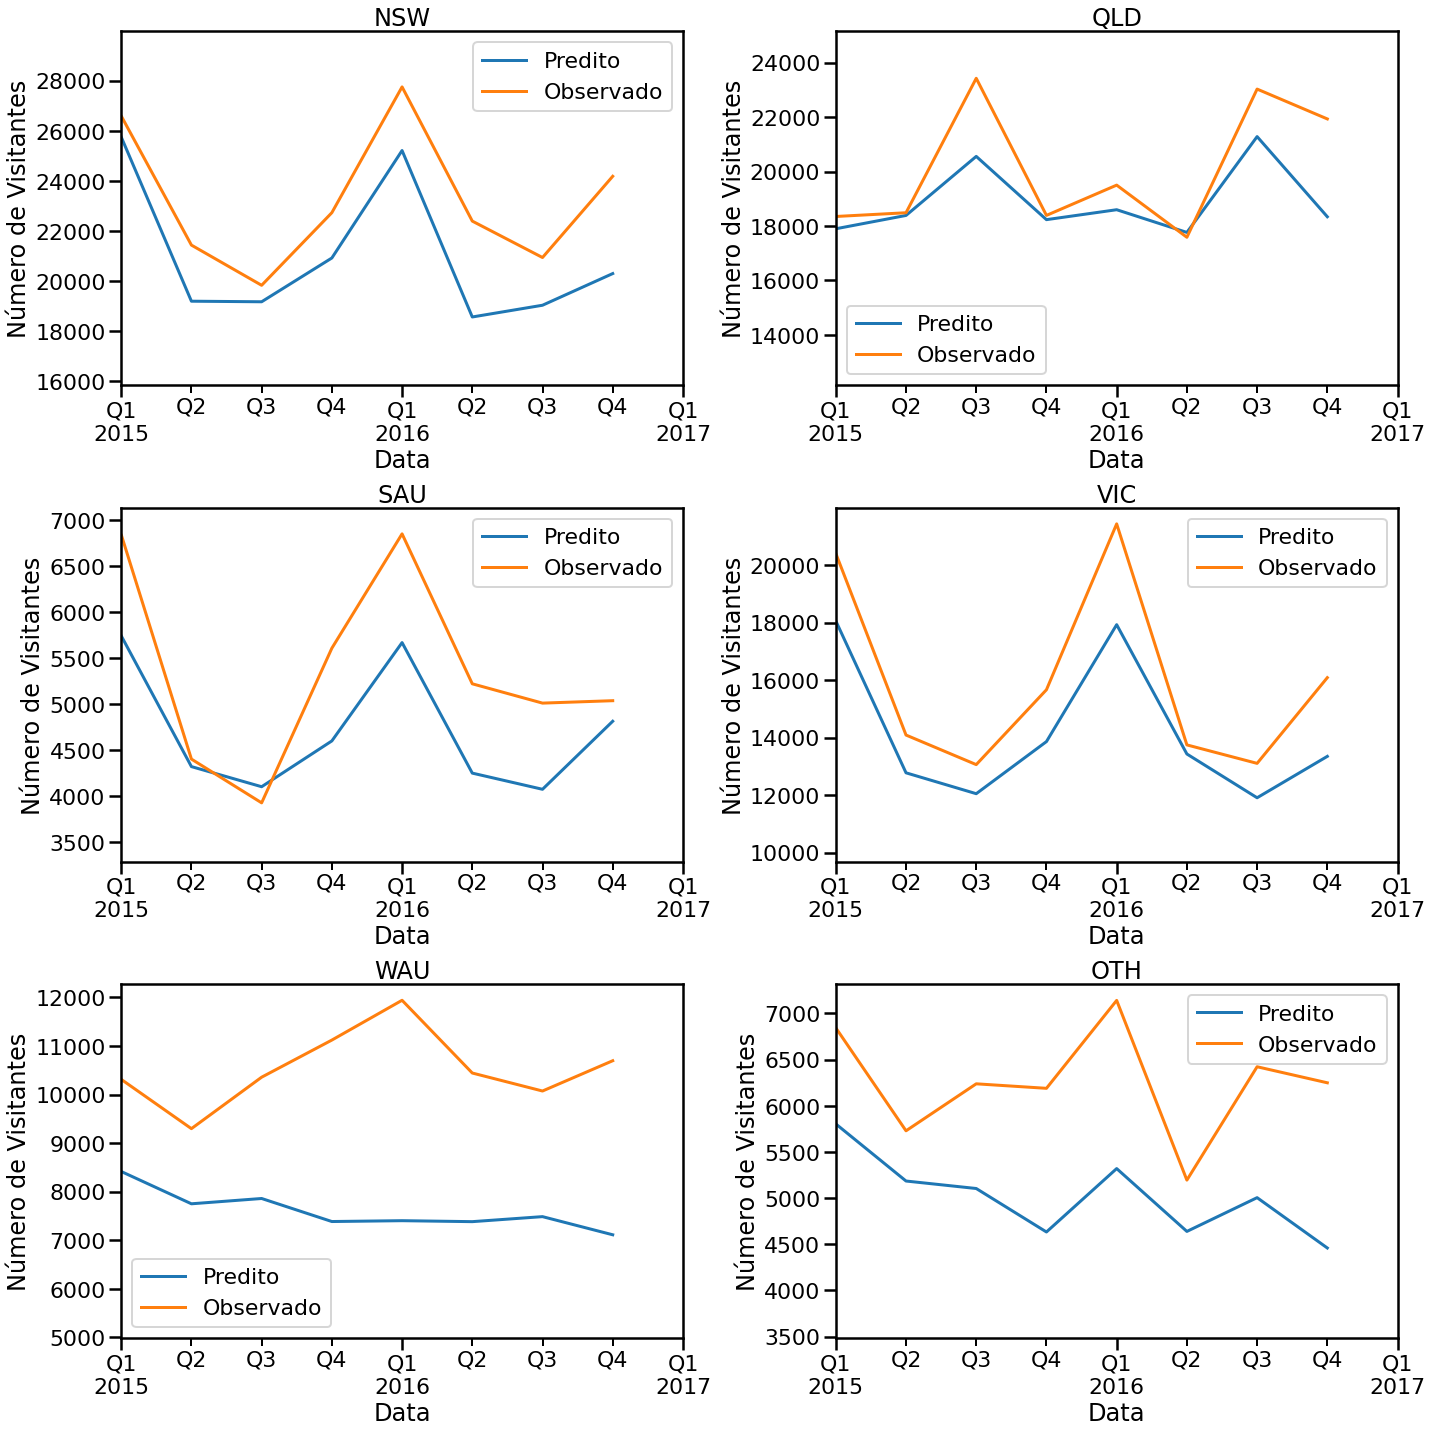

In [256]:
fig, axes = plt.subplots(3, 2, figsize=(20, 20), sharey=False)

plot_results(states, axes, pred_revised_gb_bu)
plt.tight_layout()

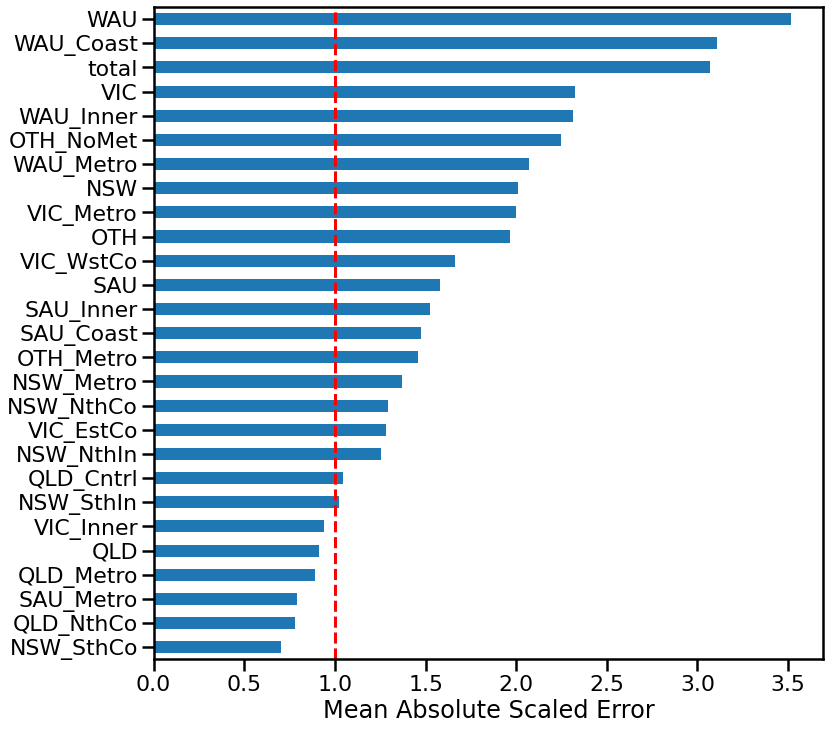

In [257]:
plot_mase_error(train_val, test, pred_revised_gb_bu)

In [258]:
collect_metrics(train_val, test, pred_revised_gb_bu, name='gb_bu')
total_metrics

{'ets_bu': {'mae': 6426.76, 'smape': 8.28, 'mase': 1.9668334782452996},
 'ets_ols': {'mae': 4604.64, 'smape': 5.89, 'mase': 1.4091947983236526},
 'ets_td': {'mae': 13778.68, 'smape': 18.66, 'mase': 4.2168002464599095},
 'arima_bu': {'mae': 8524.06, 'smape': 11.02, 'mase': 2.6086865861276927},
 'arima_ols': {'mae': 4709.05, 'smape': 6.01, 'mase': 1.4411478236423094},
 'arima_td': {'mae': 17935.18, 'smape': 24.84, 'mase': 5.488847281432838},
 'rf_bu': {'mae': 9782.98, 'smape': 12.74, 'mase': 2.9939642173877896},
 'rf_ols': {'mae': 9740.69, 'smape': 12.55, 'mase': 2.981021491909413},
 'rf_td': {'mae': 15890.67, 'smape': 21.8, 'mase': 4.863150286999006},
 'gb_bu': {'mae': 10023.15, 'smape': 13.05, 'mase': 3.0674654127962455}}

#### Top-Down

In [259]:
pred_revised_gb_td = gb_model.predict_revised(sum_mat, method='AHP', ht=ht, yhat_columns=test.columns.tolist())
pred_revised_gb_td = pred_revised_gb_td*10

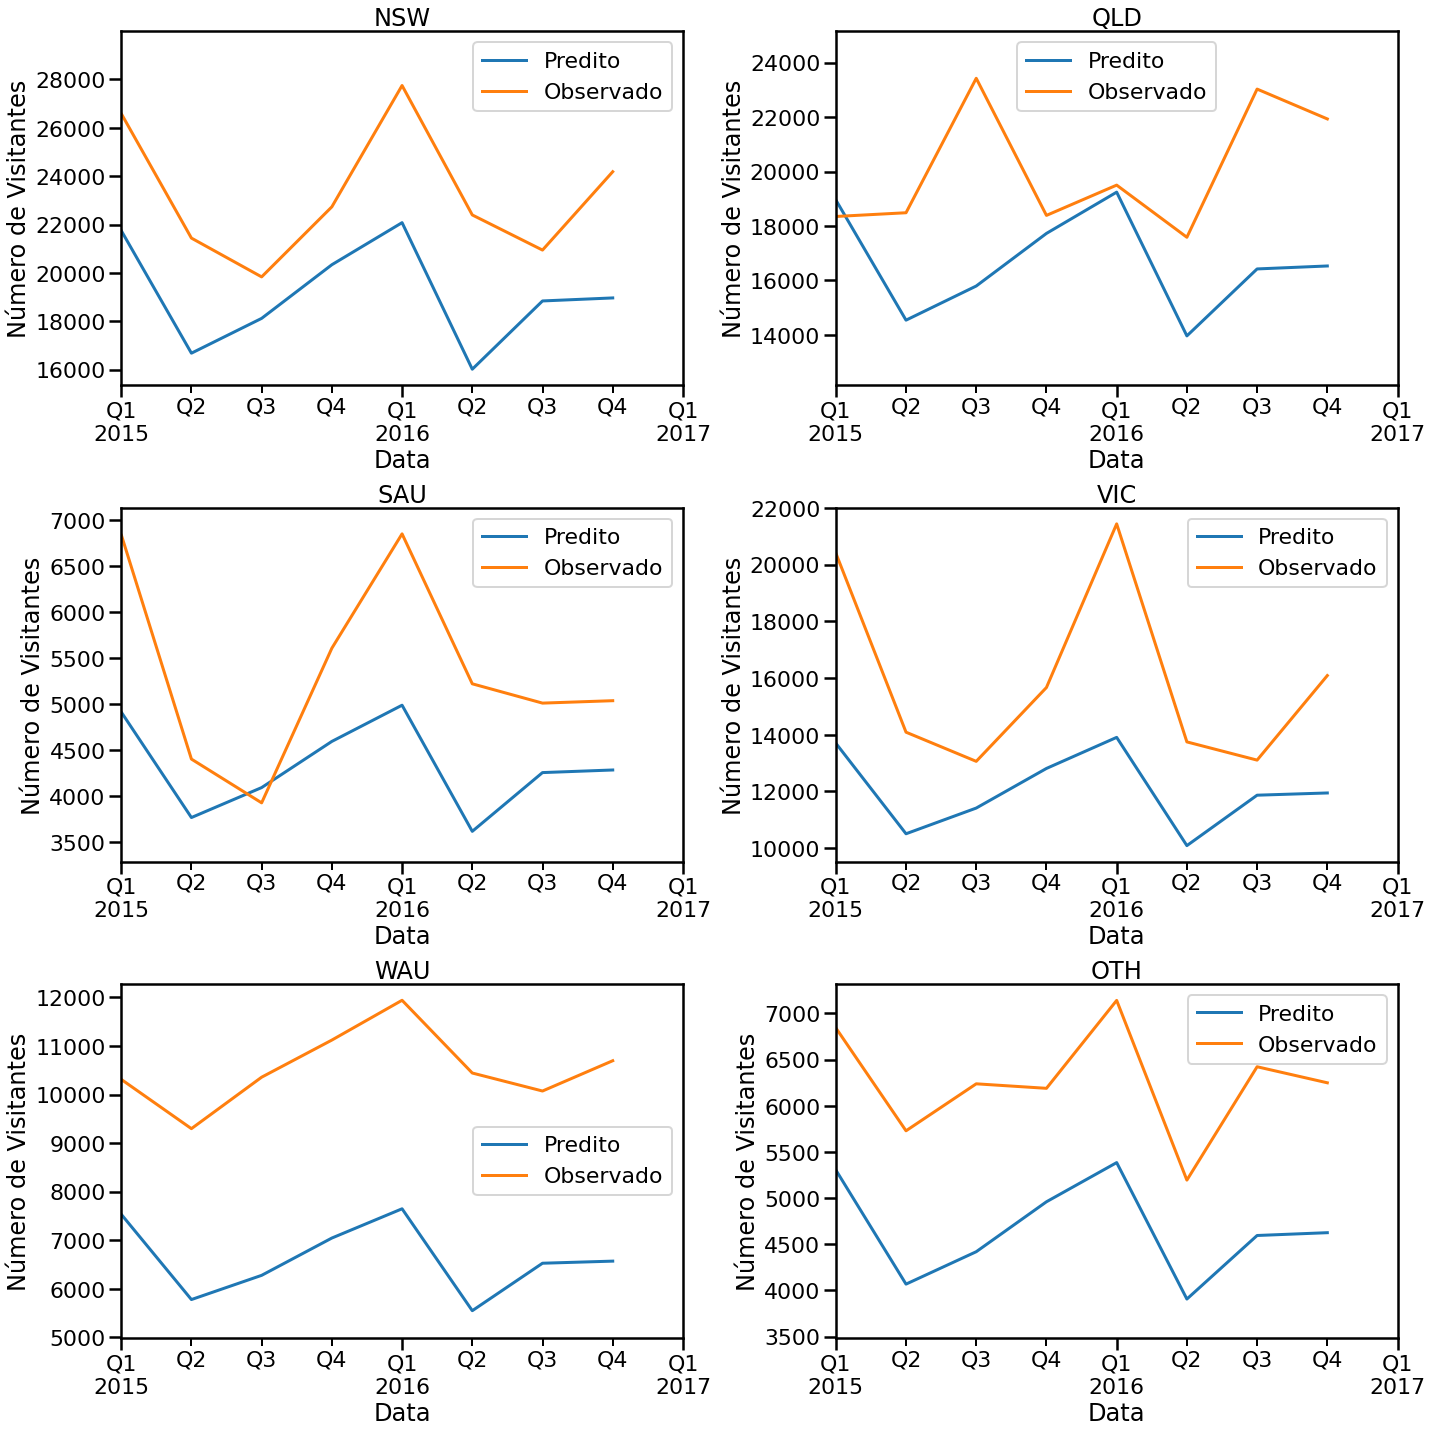

In [260]:
fig, axes = plt.subplots(3, 2, figsize=(20, 20), sharey=False)

plot_results(states, axes, pred_revised_gb_td)
plt.tight_layout()

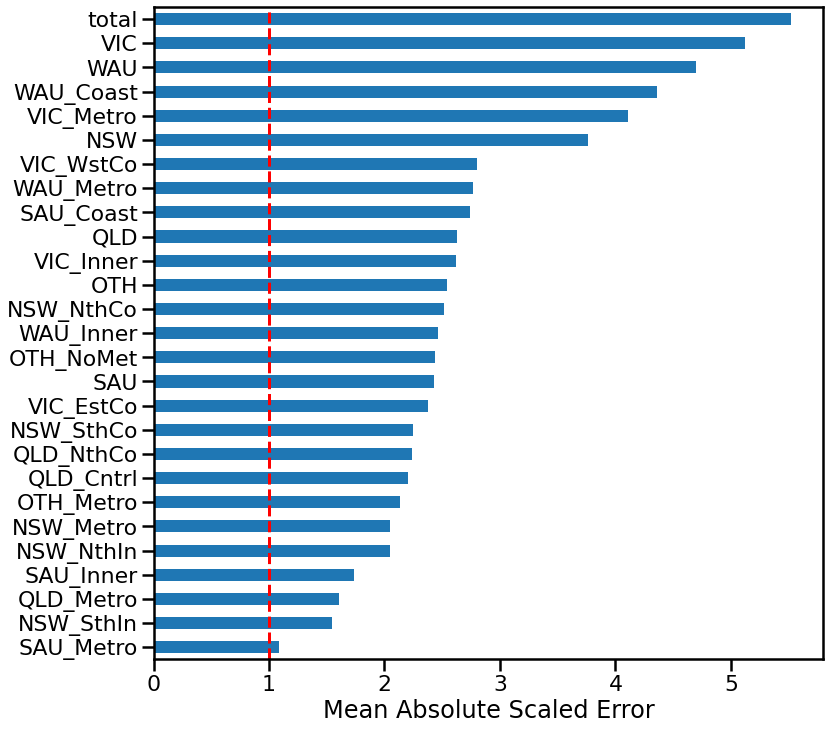

In [261]:
plot_mase_error(train_val, test, pred_revised_gb_td)

In [262]:
collect_metrics(train_val, test, pred_revised_gb_td, name='gb_td')
total_metrics

{'ets_bu': {'mae': 6426.76, 'smape': 8.28, 'mase': 1.9668334782452996},
 'ets_ols': {'mae': 4604.64, 'smape': 5.89, 'mase': 1.4091947983236526},
 'ets_td': {'mae': 13778.68, 'smape': 18.66, 'mase': 4.2168002464599095},
 'arima_bu': {'mae': 8524.06, 'smape': 11.02, 'mase': 2.6086865861276927},
 'arima_ols': {'mae': 4709.05, 'smape': 6.01, 'mase': 1.4411478236423094},
 'arima_td': {'mae': 17935.18, 'smape': 24.84, 'mase': 5.488847281432838},
 'rf_bu': {'mae': 9782.98, 'smape': 12.74, 'mase': 2.9939642173877896},
 'rf_ols': {'mae': 9740.69, 'smape': 12.55, 'mase': 2.981021491909413},
 'rf_td': {'mae': 15890.67, 'smape': 21.8, 'mase': 4.863150286999006},
 'gb_bu': {'mae': 10023.15, 'smape': 13.05, 'mase': 3.0674654127962455},
 'gb_td': {'mae': 18047.61, 'smape': 25.14, 'mase': 5.523255975334203}}

#### Optimal Combination

In [263]:
pred_revised_gb_ols = gb_model.predict_revised(sum_mat, method='OLS', ht=ht, yhat_columns=test.columns.tolist())

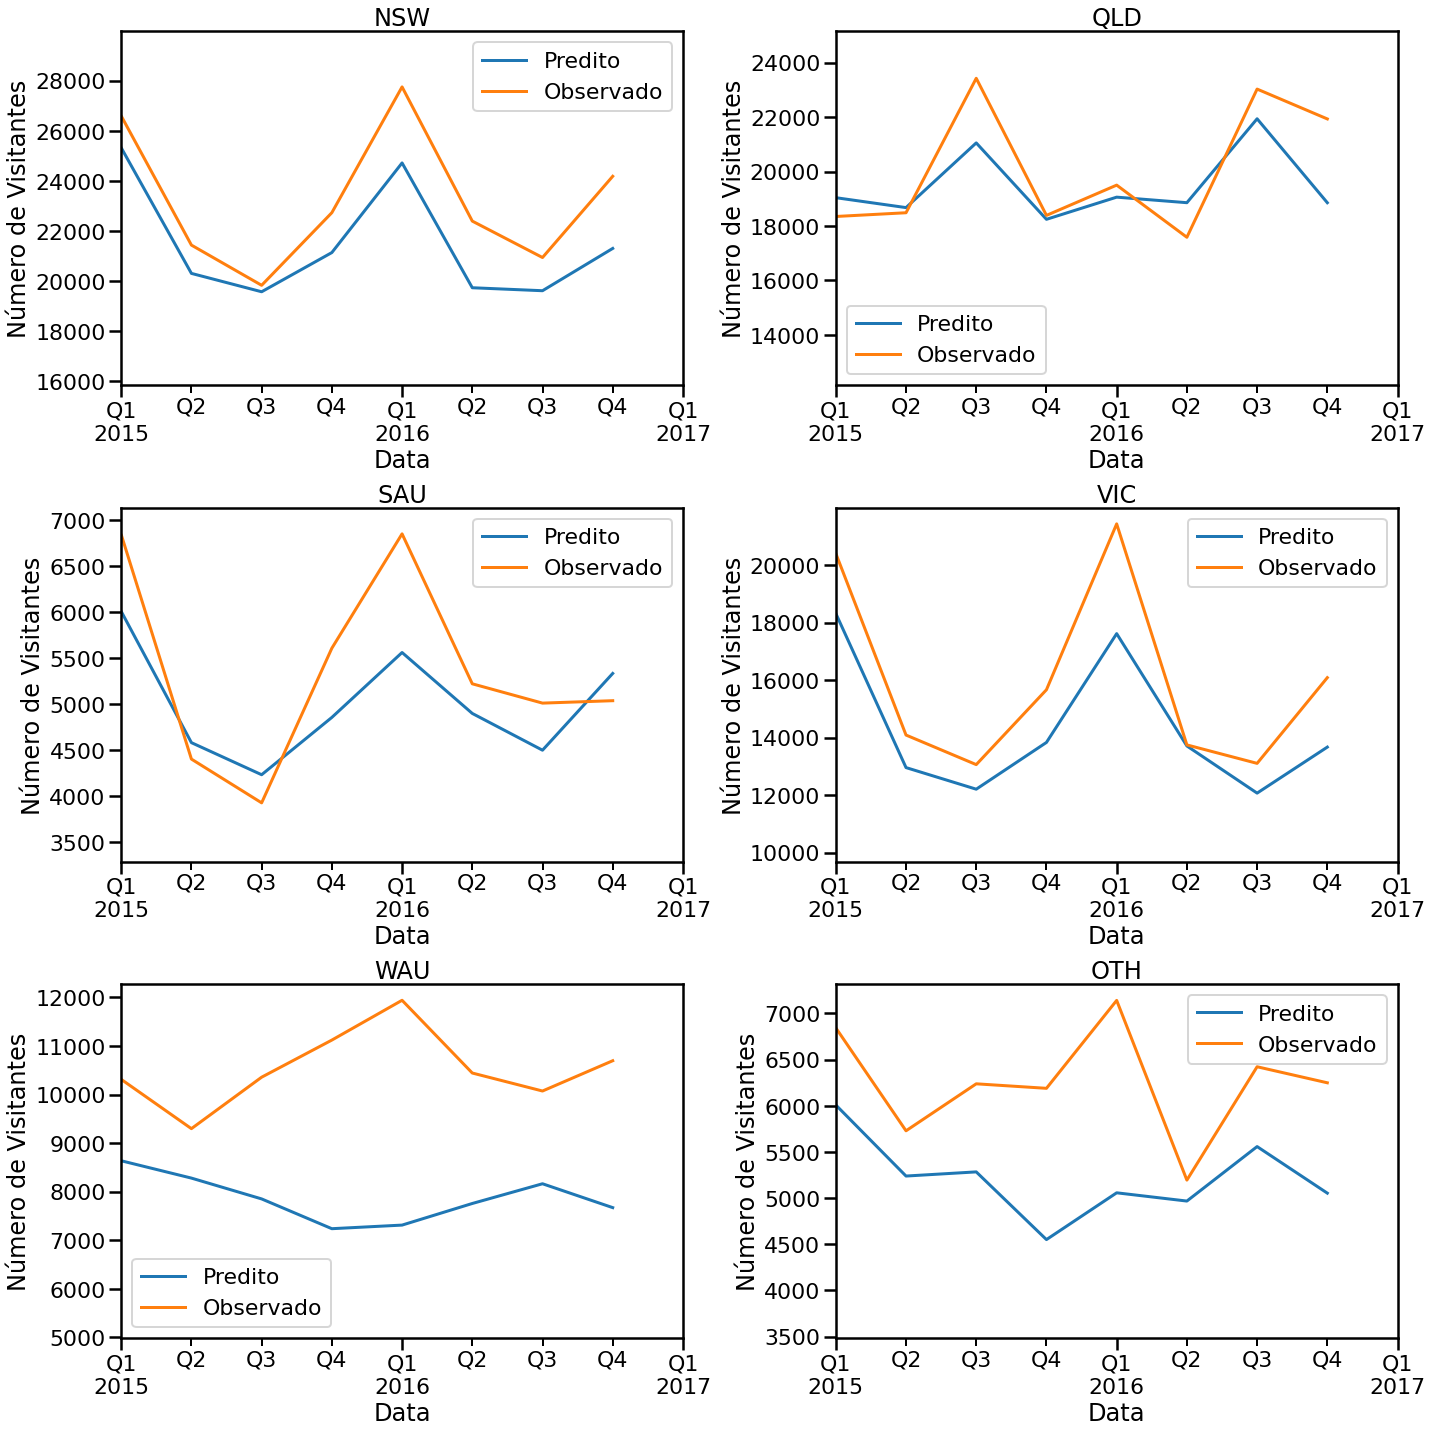

In [264]:
fig, axes = plt.subplots(3, 2, figsize=(20, 20), sharey=False)

plot_results(states, axes, pred_revised_gb_ols)
plt.tight_layout()

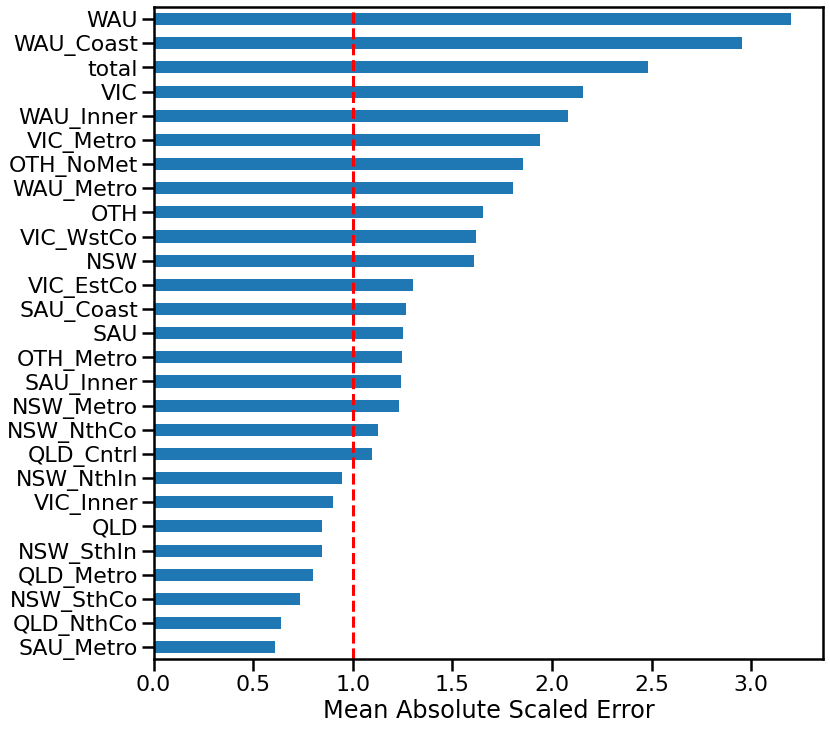

In [265]:
plot_mase_error(train_val, test, pred_revised_gb_ols)

In [266]:
collect_metrics(train_val, test, pred_revised_gb_ols, name='gb_ols')
total_metrics

{'ets_bu': {'mae': 6426.76, 'smape': 8.28, 'mase': 1.9668334782452996},
 'ets_ols': {'mae': 4604.64, 'smape': 5.89, 'mase': 1.4091947983236526},
 'ets_td': {'mae': 13778.68, 'smape': 18.66, 'mase': 4.2168002464599095},
 'arima_bu': {'mae': 8524.06, 'smape': 11.02, 'mase': 2.6086865861276927},
 'arima_ols': {'mae': 4709.05, 'smape': 6.01, 'mase': 1.4411478236423094},
 'arima_td': {'mae': 17935.18, 'smape': 24.84, 'mase': 5.488847281432838},
 'rf_bu': {'mae': 9782.98, 'smape': 12.74, 'mase': 2.9939642173877896},
 'rf_ols': {'mae': 9740.69, 'smape': 12.55, 'mase': 2.981021491909413},
 'rf_td': {'mae': 15890.67, 'smape': 21.8, 'mase': 4.863150286999006},
 'gb_bu': {'mae': 10023.15, 'smape': 13.05, 'mase': 3.0674654127962455},
 'gb_td': {'mae': 18047.61, 'smape': 25.14, 'mase': 5.523255975334203},
 'gb_ols': {'mae': 8109.66, 'smape': 10.33, 'mase': 2.4818657218859315}}

In [267]:
pd.DataFrame(total_metrics).T

mae  smape      mase
ets_bu      6426.76   8.28  1.966833
ets_ols     4604.64   5.89  1.409195
ets_td     13778.68  18.66  4.216800
arima_bu    8524.06  11.02  2.608687
arima_ols   4709.05   6.01  1.441148
arima_td   17935.18  24.84  5.488847
rf_bu       9782.98  12.74  2.993964
rf_ols      9740.69  12.55  2.981021
rf_td      15890.67  21.80  4.863150
gb_bu      10023.15  13.05  3.067465
gb_td      18047.61  25.14  5.523256
gb_ols      8109.66  10.33  2.481866

In [ ]:
pd.concat(mase, axis=1)